# Drought Analysis at State Scale

This code was created to calculate the slope and perform our drought analysis on the statewide scale using all available wells.

To run this code, you need to follow all of the DataPreprocessing instructions.

Total time to run on my machine:

In [1]:
# Packages and paths

import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
#import earthpy as et
import scipy.stats as sp
from scipy.stats import kendalltau, pearsonr, spearmanr
import sys

# Add the path to the Utils folder
utils_path = os.path.abspath(os.path.join('..', 'Utils'))
if utils_path not in sys.path:
    sys.path.append(utils_path)

# Now you can import the functions from CustomFunctions.py
import CustomFunctions as cf

# Local paths
inputpath = '../../Data/Input'
outputpath = '../../Data/Output/Local'

In [2]:
# ==== Reading in the data ====
# Importing GRACE analyses
filepath = filepath = outputpath+'/grace_stateavg_yearly.csv'
grace_yearly = pd.read_csv(filepath, index_col=0)
grace_yearly = grace_yearly[:-1]
print("GRACE data loaded.")

# Read in the annual time series database
filename_ts = 'Wells55_GWSI_WLTS_DB_annual_updated.csv'
filepath = os.path.join(outputpath, filename_ts)
annual_db = pd.read_csv(filepath, header=1, index_col=0)
print("Well data loaded.")

annual_db = annual_db[1:168102]
annual_db.index.astype('int64')
annual_db2 = annual_db.reset_index(inplace=True)
annual_db2 = annual_db.rename(columns = {'year':'Combo_ID'})
annual_db2 = annual_db2.set_index('Combo_ID')
annual_db2.head()
print("Well data formatted.")

# Read in the drought indices

#  Input the date you downloaded the drought files
date_downloaded = "06102024"

drought_indices = pd.read_csv(f'{inputpath}/Yearly_DroughtIndices_updated{date_downloaded}.csv') #this version doesn't have PHDI so adjust accordingly
drought_indices = drought_indices.set_index('In_year')
print("Drought data loaded and formatted.")

GRACE data loaded.
Well data loaded.
Well data formatted.
Drought data loaded and formatted.


Creating Colors

In [3]:
# %% Creating colors

# Color blind palette
# https://jacksonlab.agronomy.wisc.edu/2016/05/23/15-level-colorblind-friendly-palette/
cblind =["#000000","#004949","#009292","#ff6db6","#ffb6db",
 "#490092","#006ddb","#b66dff","#6db6ff","#b6dbff",
 "#920000","#924900","#db6d00","#24ff24","#ffff6d"]

# grace_color = '#A92B2A'
grace_color = "#858585"
# az_wells_color = '#1D4E77'
az_wells_color = 'black'

# Drought Colors
drought_color = '#ffa6b8'
wet_color = '#b8d3f2'

Establishing Drought Years

In [4]:
# %% Drought dictionary
DROUGHT_YEARS = {
        # 1:[1989,1990]
        # ,2:[1996]
        3:[2002,2003]
        ,4:[2006,2007]
        ,5:[2012,2013,2014]
        ,6:[2018]
        ,7:[2021]}

print(DROUGHT_YEARS)

{3: [2002, 2003], 4: [2006, 2007], 5: [2012, 2013, 2014], 6: [2018], 7: [2021]}


In [5]:
yearlabels = [
                # "1989-1990"
        #       ,'1996',
              '2002-2003','2006-2007','2012-2014','2018','2021'
              ,'Normal/Wet Years'
        ]

Setting up the analysis period

In [6]:
minyear_grace = 2002 # Year GRACE was launched
maxyear = 2022

# %% Figure out which water level database you want
cat_wl2 = grace_yearly.copy() 

# Water Analysis period
wlanalysis_period_grace = cat_wl2[(cat_wl2.index>=minyear_grace)&(cat_wl2.index<=maxyear)]

In [7]:
# Enter min year and max year of timeframe
# minyear = 2000 # When Lakemead started to go into drought
minyear_wells = 2002

# %% Figure out which water level database you want
cat_wl2 = annual_db2.copy()
cat_wl2 = cat_wl2.transpose()
cat_wl2 = cat_wl2.reset_index()
cat_wl2['index'] = pd.to_numeric(cat_wl2['index'], errors='coerce')
cat_wl2.index = cat_wl2.index.astype('int64')
cat_wl2 = cat_wl2.set_index('index')

# Water Analysis period for wells
wlanalysis_period_AZwells = cat_wl2[(cat_wl2.index>=minyear_wells)&(cat_wl2.index<=maxyear)]
wlanalysis_period_AZwells.head()

Combo_ID,83578,84067,84442,84455,84460,84598,84614,84626,84630,84633,...,364515111034001,364528113101401,364529109292701,364537109390801,364550112401201,364552109315901,364613109510801,364614114054601,364619114054801,364625113595501
index,,,,,,,,,,,,,,,,,,,,,
2002.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-36.8,NaN,NaN,NaN,NaN,NaN,NaN
2005.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Calculate the mean across columns for each row
average_per_year = wlanalysis_period_AZwells.mean(axis=1)

# Create a new DataFrame with years as rows and an 'Average' column
average_df_AZ = pd.DataFrame(average_per_year)

# Display the resulting DataFrame
average_df_AZ.head()

,0
index,
2002.0,214.843555
2003.0,214.888602
2004.0,208.806658
2005.0,212.319045
2006.0,216.104375


In [9]:
# Narrowing the drought indices to be during our study period
drought_indices_wells = drought_indices[(drought_indices.index>=minyear_wells)&(drought_indices.index<=maxyear)]
drought_indices_grace = drought_indices[(drought_indices.index>=2002)&(drought_indices.index<=maxyear)]

For comparing to drought indices

In [10]:
test_name = "GRACE Dataset"
ds = wlanalysis_period_grace
drought = drought_indices_grace
# If running a shifted correlation analysis,
#    change this to however many # years; 0 is no lag
lag = 0
indice = 'PDSI'
result = cf.correlation_test(ds, drought, indice, lag,test_name)
print(result)

Results for GRACE Dataset:
Kendall Correlation coefficient
 0:
  tau = -0.029
  pval = 0.8815
Spearman Correlation coefficient
 0:
  rho = -0.026
  pval = 0.911
Pearson Correlation coefficient
 0:
  rsq = 0.023
  pval = 0.5072



In [11]:
test_name = "ADWR Wells"
ds = average_df_AZ
drought = drought_indices_wells
# If running a shifted correlation analysis,
#    change this to however many # years; 0 is no lag
lag = 0
indice = 'PDSI'
result = cf.correlation_test(ds, drought, indice, lag,test_name)
print(result)

Results for ADWR Wells:
Kendall Correlation coefficient
 0:
  tau = -0.095
  pval = 0.5706
Spearman Correlation coefficient
 0:
  rho = -0.194
  pval = 0.4007
Pearson Correlation coefficient
 0:
  rsq = 0.017
  pval = 0.5734



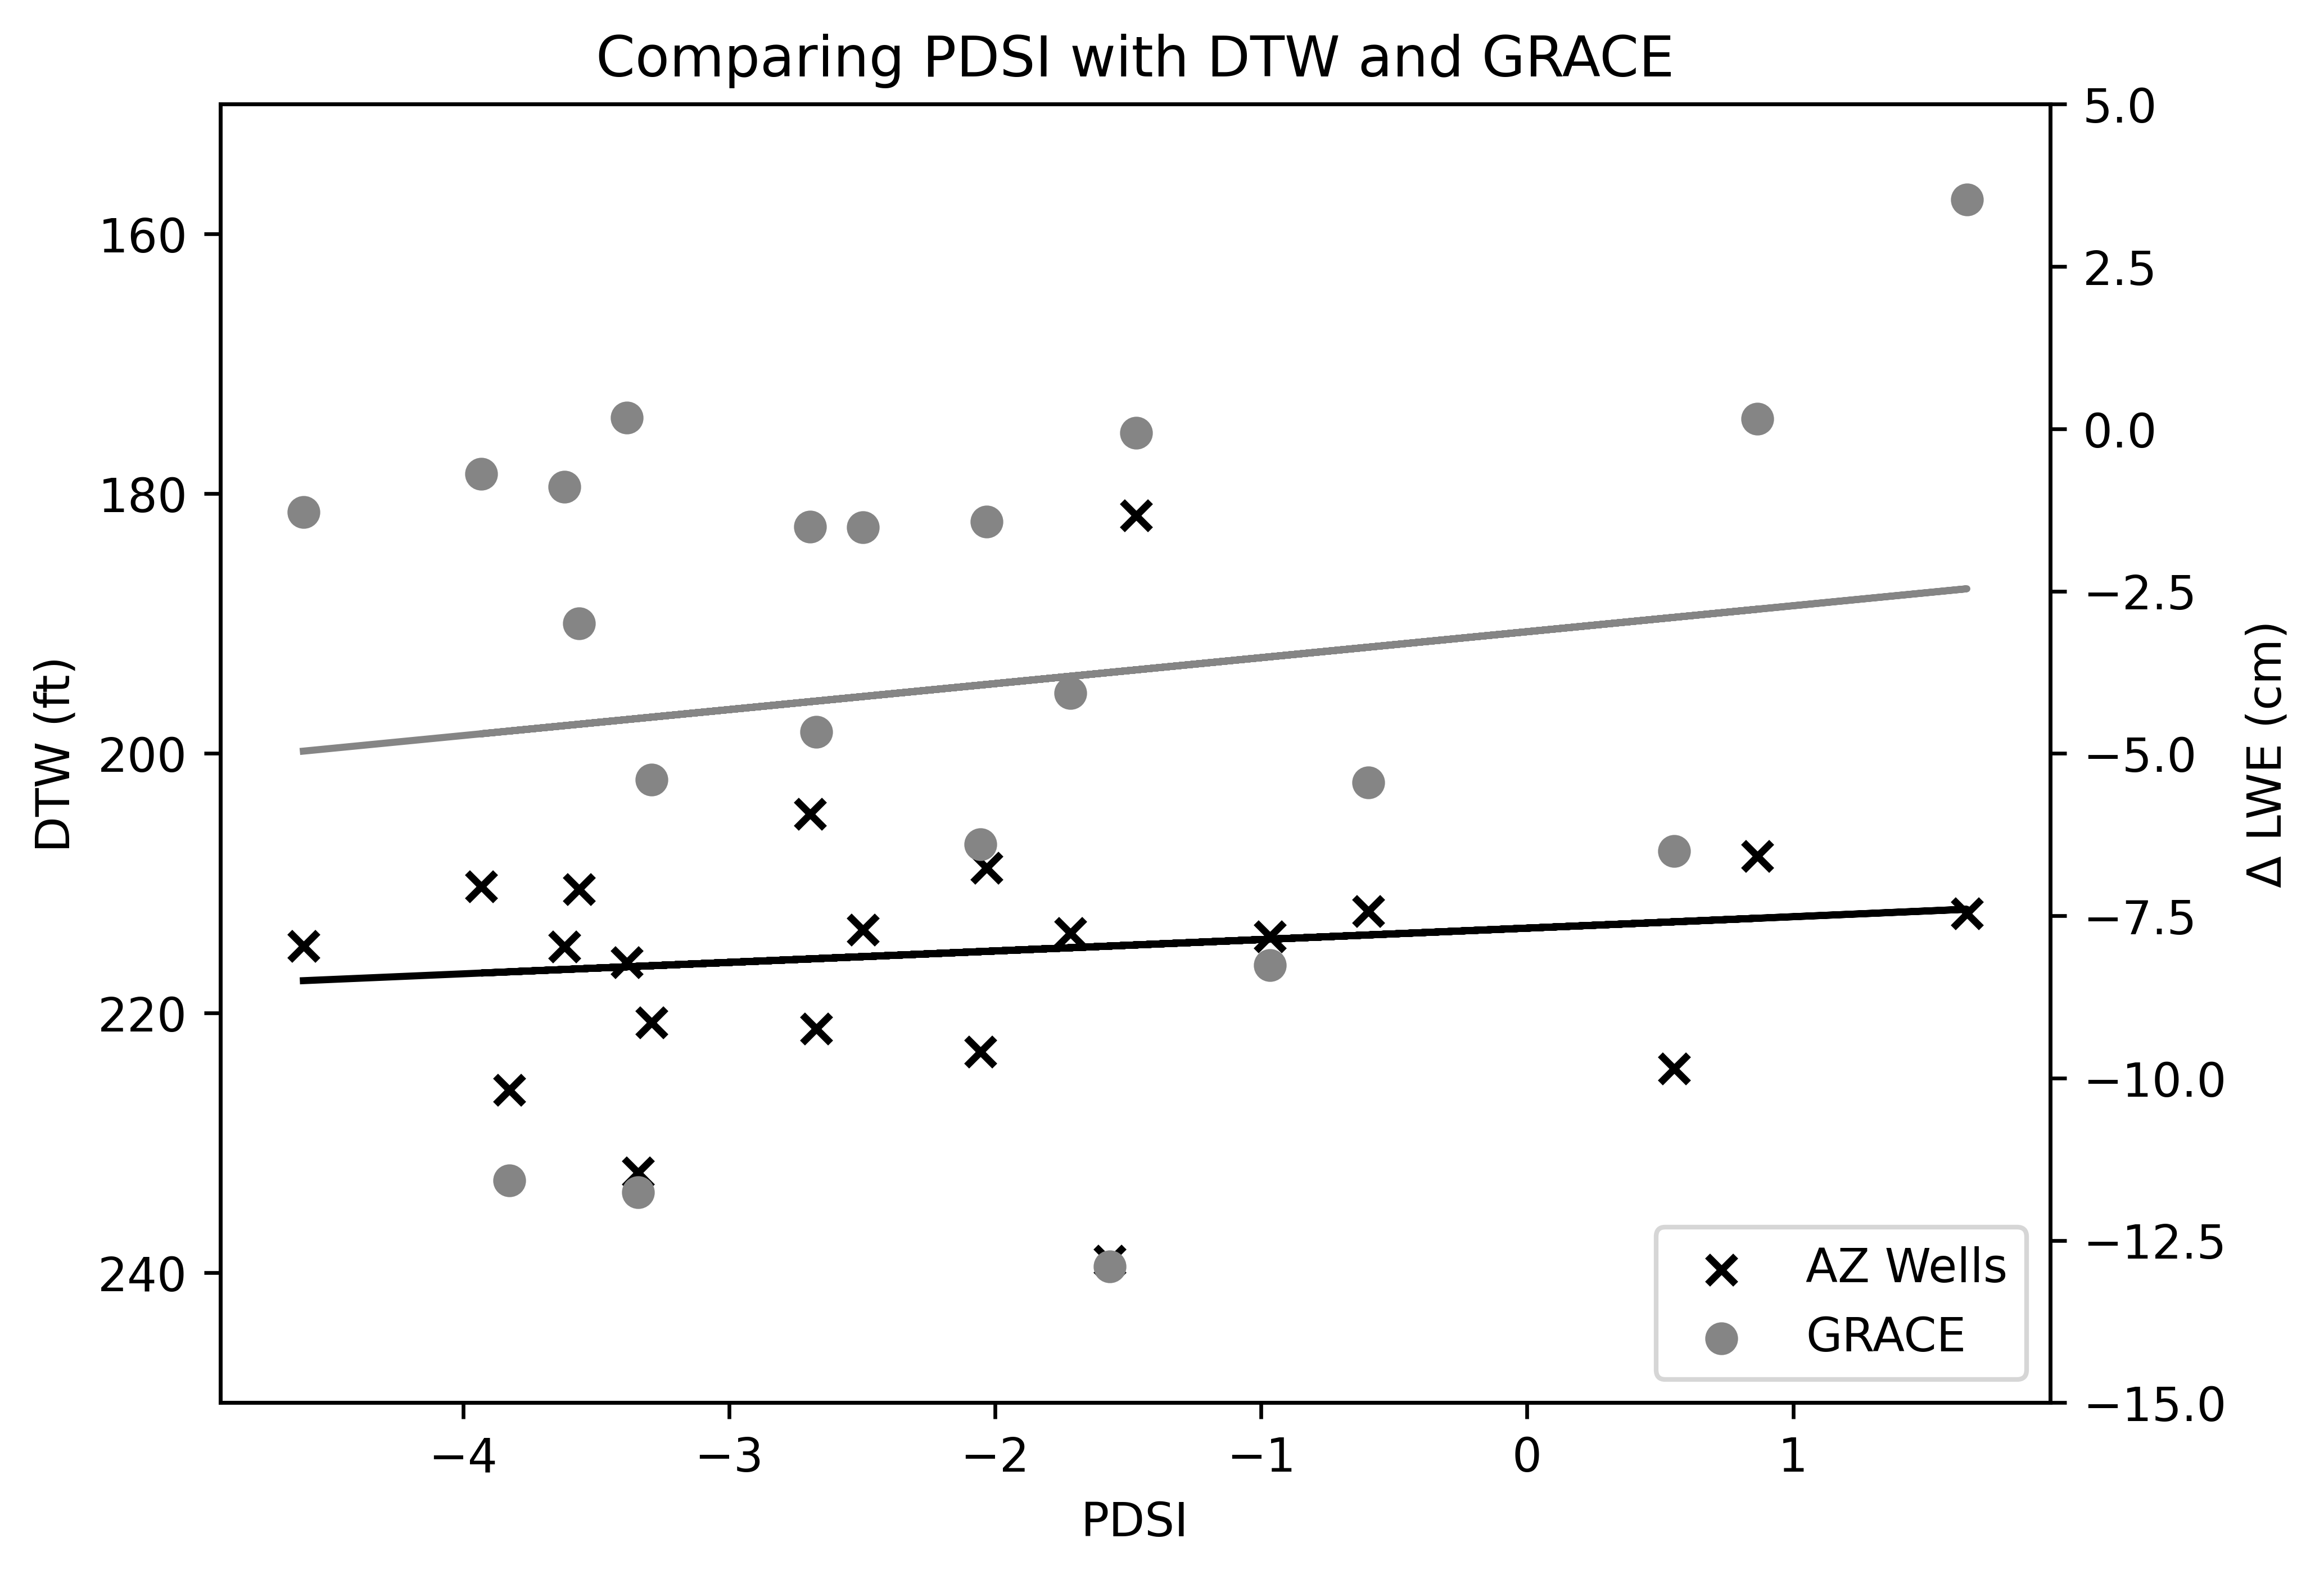

In [12]:
# %% Scatterplot of correlation values
ds = wlanalysis_period_grace
ds2 = average_df_AZ
ds2.columns = ds.columns

name = 'Comparing '+indice+' with DTW and GRACE'
# del ds['Res']
columns = ds.columns
column_list = ds.columns.tolist()
columns2 = ds2.columns
column_list2 = ds2.columns.tolist()
betterlabels = ['GRACE'] 
betterlabels2 = ['AZ Wells'] 

fig, ax = plt.subplots(figsize=(7, 5))

x = drought_indices_grace[indice]
x2 = drought_indices_wells[indice]

# AZ Wells
for i, j in zip(column_list2, betterlabels2):
    y2 = ds2[i]
    ax.scatter(x2, y2, label=j, color=az_wells_color, marker='x')  # Using marker='x' for differentiation
    z = np.polyfit(x2, y2, 1)
    p = np.poly1d(z)
    ax.plot(x2, p(x2), '-', color=az_wells_color)  # Using '--' for differentiation

# Create a secondary y-axis
ax2 = ax.twinx()

# GRACE
for i, j in zip(column_list, betterlabels):
    y = ds[i]
    ax2.scatter(x, y, label=j, color=grace_color)
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x), '-', color=grace_color)

# Reverse the order of the secondary y-axis
ax.set_ylim(250,150)
ax2.set_ylim(-15,5)

ax.set_xlabel(indice)
ax2.set_ylabel(u'Δ LWE (cm)')
ax.set_ylabel('DTW (ft)')  # Set label for the secondary axis
ax.set_title(name, loc='center')
fig.set_dpi(600)

# Combine legends for both axes
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='lower right')

plt.show()

# plt.savefig(outputpath+name, bbox_inches='tight') 

For Calculating Anomlies

In [13]:
# Anomaly's
ds = wlanalysis_period_grace.copy()
columns = ds.columns
column_list = ds.columns.tolist()
trend_df = wlanalysis_period_grace.copy()
lwe_anomalys_grace = pd.DataFrame()
for i in column_list:
        # Subtracting against the mean
        # dtw_anomalys[i] = wlanalysis_period[i] - wlanalysis_period[i].mean()
        
        # Subtracting against the slope
        df = ds[i]
        y=np.array(df.values, dtype=float)
        x=np.array(pd.to_datetime(df).index.values, dtype=float)
        slope, intercept, r_value, p_value, std_err = sp.linregress(x,y)
        # print(y)
        # slope, intercept = sp.linregress(x,y) 
        trend_df[i] = (ds.index*slope) + intercept
        lwe_anomalys_grace[i] = ds[i] - trend_df[i]
        

lwe_anomalys_grace.head()

,0
year,
2002,-3.500186
2003,-2.492875
2004,-2.413919
2005,3.172629
2006,0.429620


In [14]:
# Anomaly's
ds = average_df_AZ.copy()
columns = ds.columns
column_list = ds.columns.tolist()
trend_df = average_df_AZ.copy()
dtw_anomalys_AZwells = pd.DataFrame()
for i in column_list:
        # Subtracting against the mean
        # dtw_anomalys[i] = wlanalysis_period[i] - wlanalysis_period[i].mean()
        
        # Subtracting against the slope
        df = ds[i]
        y=np.array(df.values, dtype=float)
        x=np.array(pd.to_datetime(df).index.values, dtype=float)
        slope, intercept, r_value, p_value, std_err = sp.linregress(x,y)

        # Correcting the index to be integers
        trend_df.index = trend_df.index.astype(int)
        ds.index = ds.index.astype(int)

        trend_df[i] = (ds.index*slope) + intercept
        dtw_anomalys_AZwells[i] = ds[i] - trend_df[i]
        
dtw_anomalys_AZwells.index = dtw_anomalys_AZwells.index.astype('int64')
dtw_anomalys_AZwells.head()

,0
index,
2002,9.946906
2003,8.948762
2004,1.823628
2005,4.292824
2006,7.034963


In [15]:
test_name = "GRACE Anomaly Correlation ("+str(minyear_grace)+"-"+str(maxyear)+")"
ds = lwe_anomalys_grace
drought = drought_indices_grace
# If running a shifted correlation analysis,
#    change this to however many # years; 0 is no lag
lag = 0
indice = 'PDSI'
result = cf.correlation_test(ds, drought, indice, lag,test_name)
print(result)

Results for GRACE Anomaly Correlation (2002-2022):
Kendall Correlation coefficient
 0:
  tau = 0.429
  pval = 0.0061
Spearman Correlation coefficient
 0:
  rho = 0.59
  pval = 0.0049
Pearson Correlation coefficient
 0:
  rsq = 0.393
  pval = 0.0023



In [16]:
test_name = "ADWR Well Anomalies ("+str(minyear_wells)+"-"+str(maxyear)+")"
ds = dtw_anomalys_AZwells
drought = drought_indices_wells
# If running a shifted correlation analysis,
#    change this to however many # years; 0 is no lag
lag = 0
indice = 'PDSI'
result = cf.correlation_test(ds, drought, indice, lag,test_name)
print(result)

Results for ADWR Well Anomalies (2002-2022):
Kendall Correlation coefficient
 0:
  tau = -0.229
  pval = 0.1576
Spearman Correlation coefficient
 0:
  rho = -0.347
  pval = 0.1236
Pearson Correlation coefficient
 0:
  rsq = 0.077
  pval = 0.2227



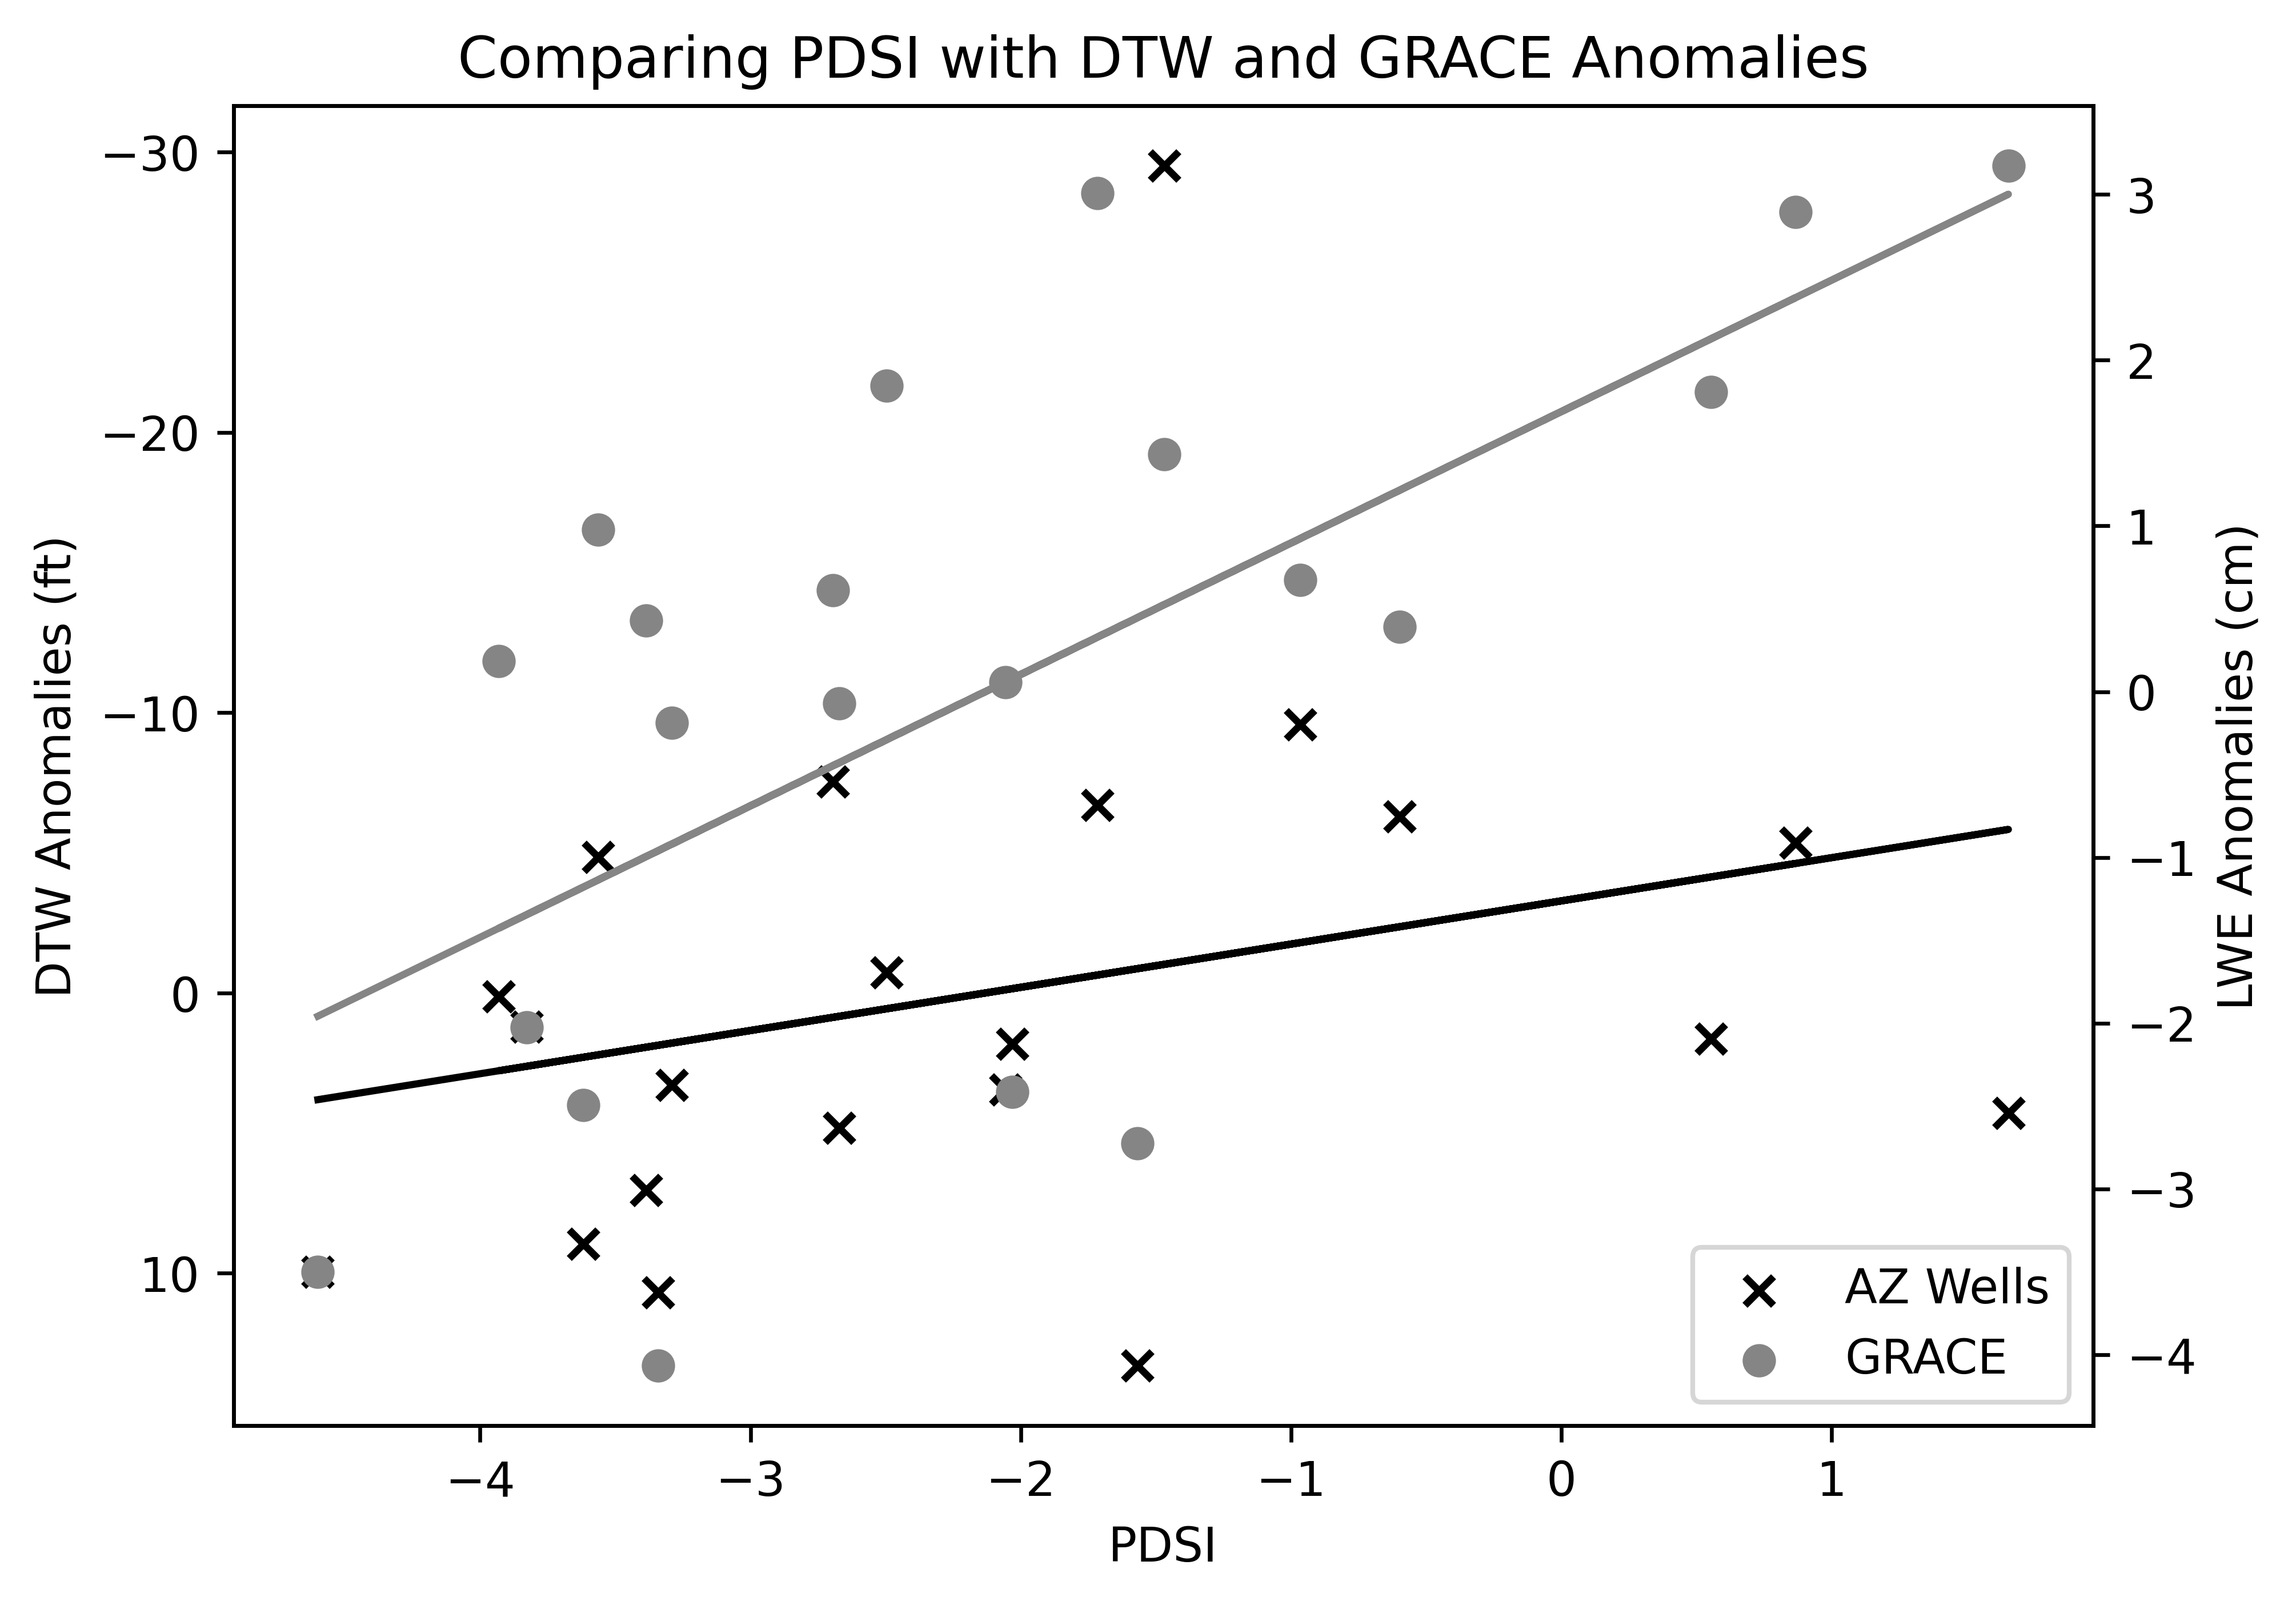

In [17]:
indice = 'PDSI'
# Scatterplot of correlation values
ds = lwe_anomalys_grace
ds2 = dtw_anomalys_AZwells
ds2.columns = ds.columns

name = 'Comparing '+indice+' with DTW and GRACE Anomalies'
columns = ds.columns
column_list = ds.columns.tolist()
columns2 = ds2.columns
column_list2 = ds2.columns.tolist()
betterlabels = ['GRACE'] 
betterlabels2 = ['AZ Wells'] 

fig, ax = plt.subplots(figsize=(7, 5))

x = drought_indices_grace[indice]
x2 = drought_indices_wells[indice]

# AZ Wells
for i, j in zip(column_list2, betterlabels2):
    y2 = ds2[i]
    ax.scatter(x2, y2, label=j, color=az_wells_color, marker='x')  # Using marker='x' for differentiation
    z = np.polyfit(x2, y2, 1)
    p = np.poly1d(z)
    ax.plot(x2, p(x2), '-', color=az_wells_color)  # Using '--' for differentiation

# Create a secondary y-axis
ax2 = ax.twinx()

# GRACE
for i, j in zip(column_list, betterlabels):
    y = ds[i]
    ax2.scatter(x, y, label=j, color=grace_color)
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x), '-', color=grace_color)

# Reverse the order of the secondary y-axis
# ax.set_ylim(250,150)
# ax2.set_ylim(-15,5)
ax.set_ylim(ax.get_ylim()[::-1])

ax.set_xlabel(indice)
ax2.set_ylabel('LWE Anomalies (cm)')
ax.set_ylabel('DTW Anomalies (ft)')  # Set label for the secondary axis
ax.set_title(name, loc='center')
fig.set_dpi(600)

# Combine legends for both axes
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='lower right')

plt.show()

# plt.savefig(outputpath+name, bbox_inches='tight') 

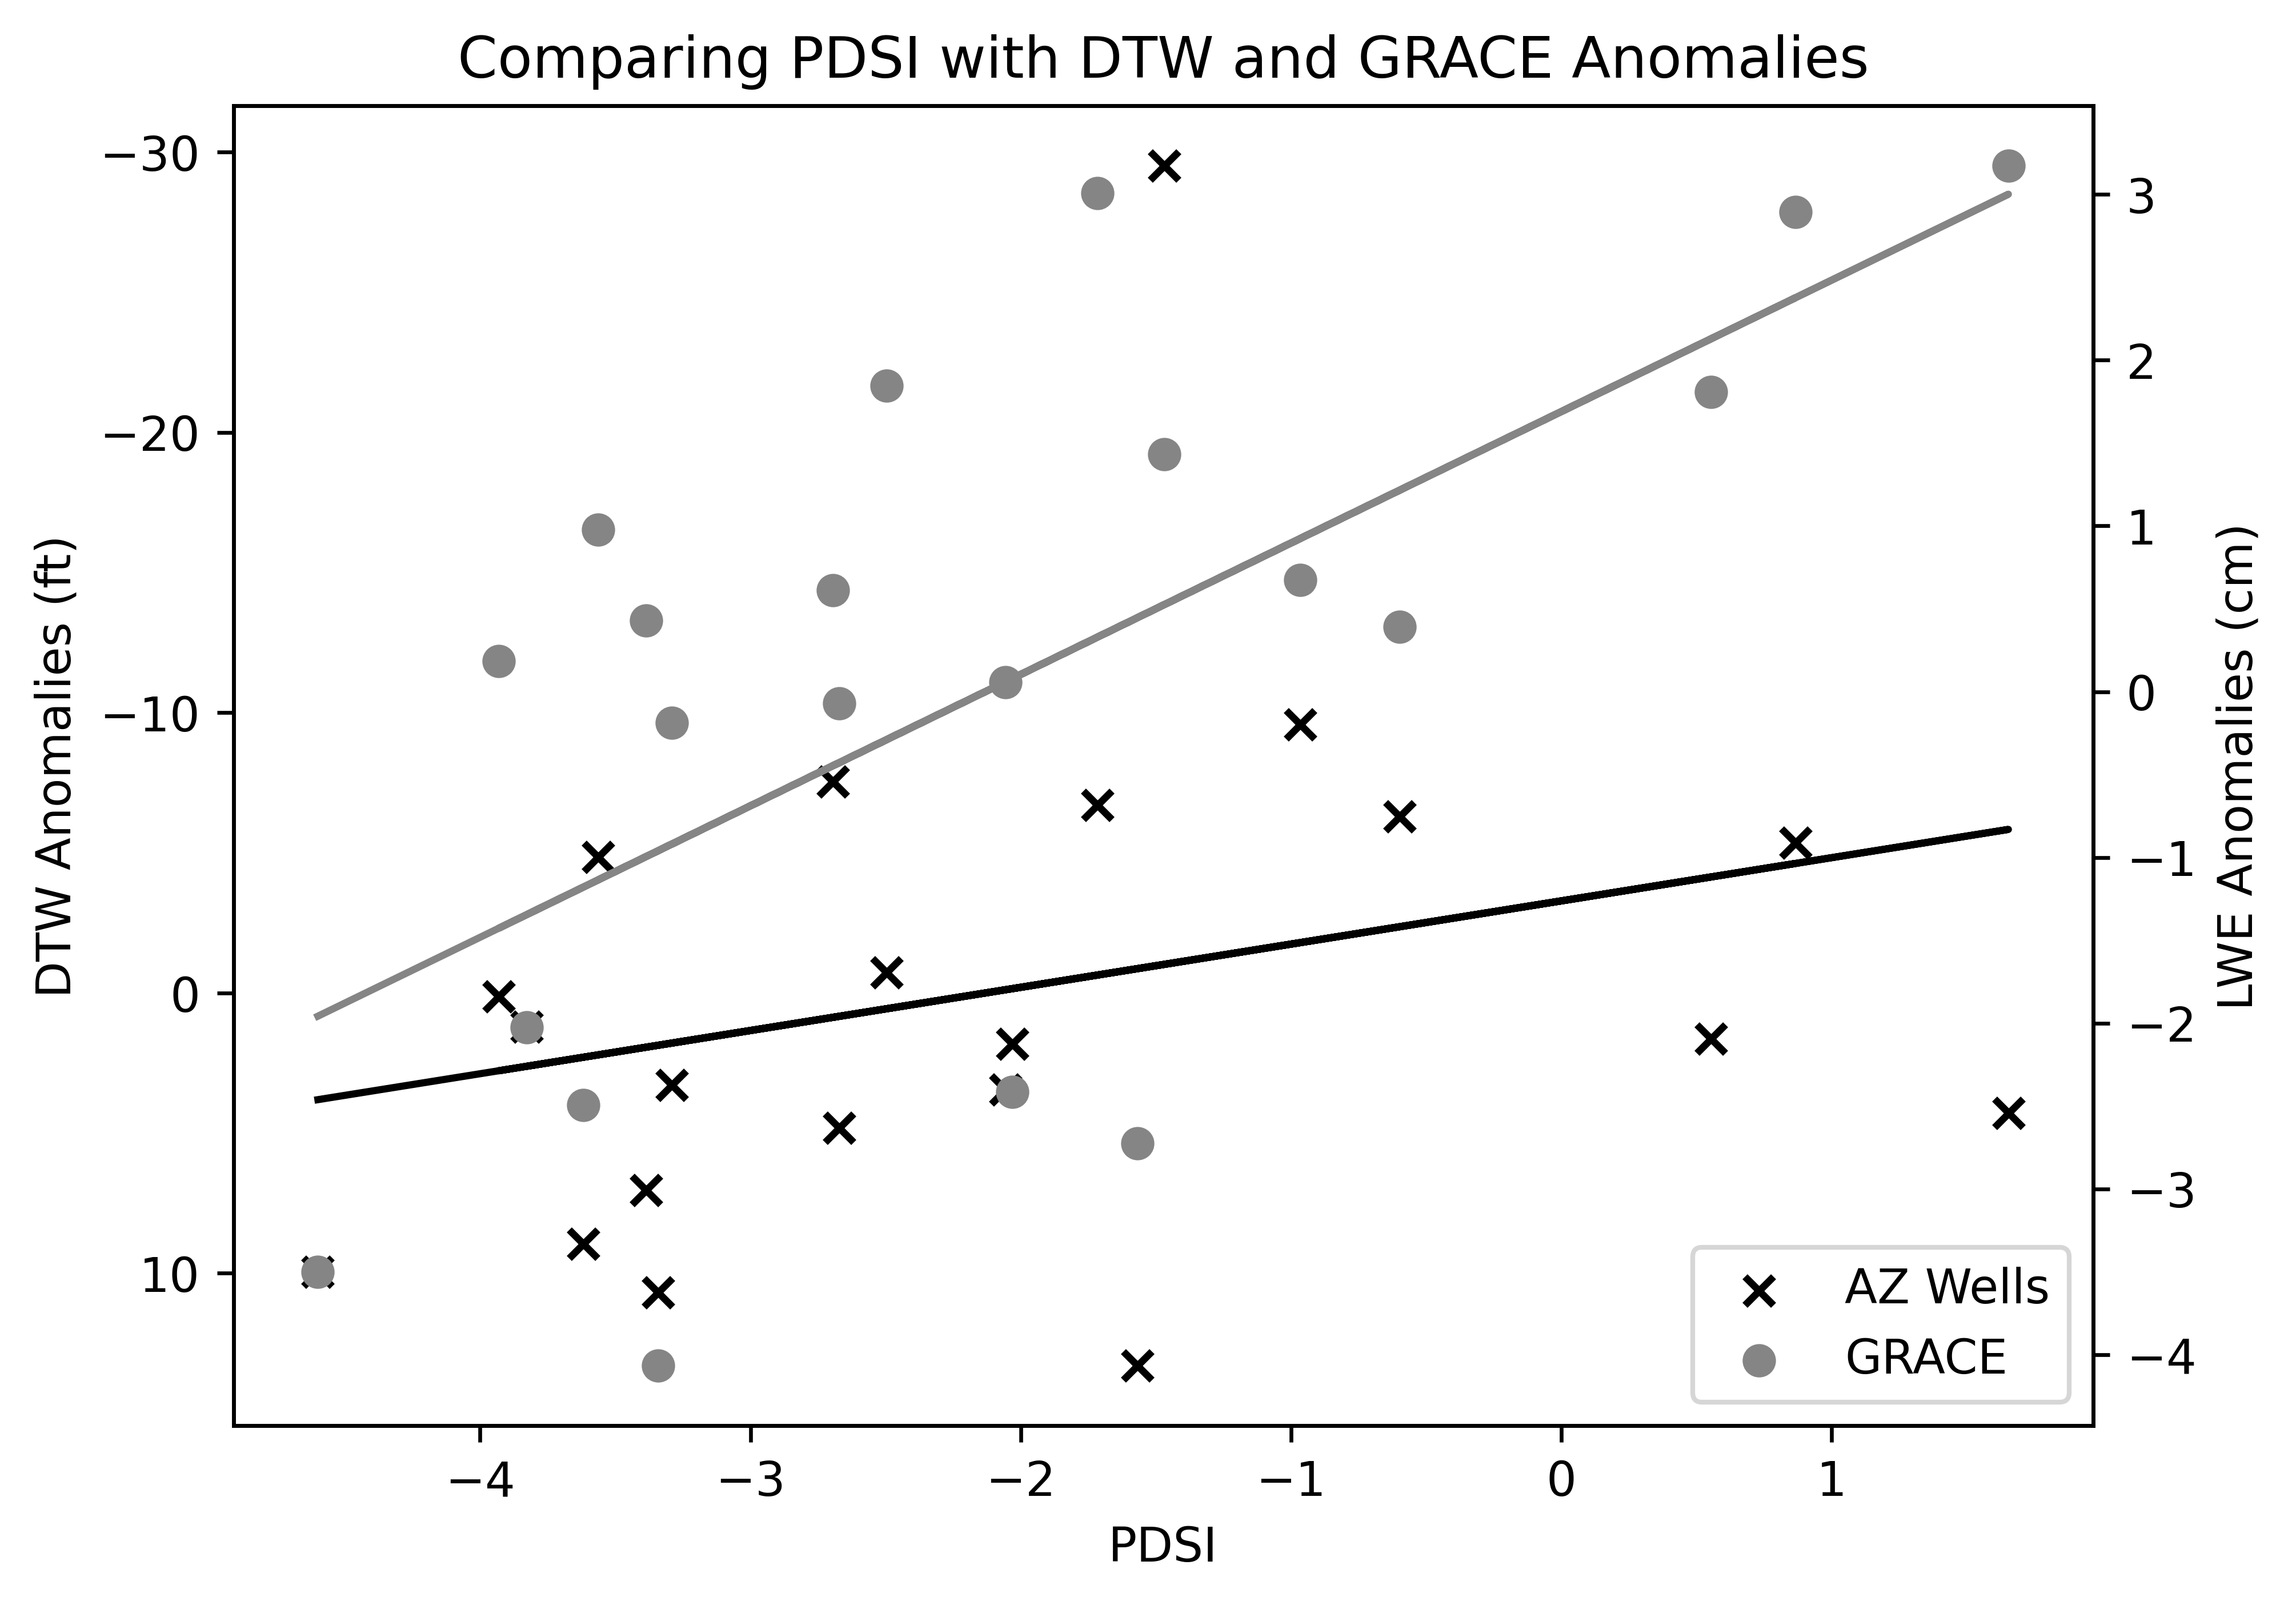

Results for GRACE Anomaly Correlation (2002-2022):
Kendall Correlation coefficient
 0:
  tau = 0.429
  pval = 0.0061
Spearman Correlation coefficient
 0:
  rho = 0.59
  pval = 0.0049
Pearson Correlation coefficient
 0:
  rsq = 0.393
  pval = 0.0023
Results for ADWR Well Anomalies (2002-2022):
Kendall Correlation coefficient
 0:
  tau = -0.229
  pval = 0.1576
Spearman Correlation coefficient
 0:
  rho = -0.347
  pval = 0.1236
Pearson Correlation coefficient
 0:
  rsq = 0.077
  pval = 0.2227



In [18]:
ds = lwe_anomalys_grace
ds2 = dtw_anomalys_AZwells
drought = drought_indices_wells

indice = 'PDSI'
# If running a shifted correlation analysis,
#    change this to however many # years; 0 is no lag
lag = 0

betterlabels = 'GRACE' 
betterlabels2 = 'AZ Wells' 

test_name = "GRACE Anomaly Correlation ("+str(minyear_grace)+"-"+str(maxyear)+")"
test_name2 = "ADWR Well Anomalies ("+str(minyear_wells)+"-"+str(maxyear)+")"

result = cf.correlation_test_2y(ds,ds2,drought,indice,lag
                                ,test_name,test_name2
                                ,betterlabels,betterlabels2
                                ,grace_color,az_wells_color)
print(result)

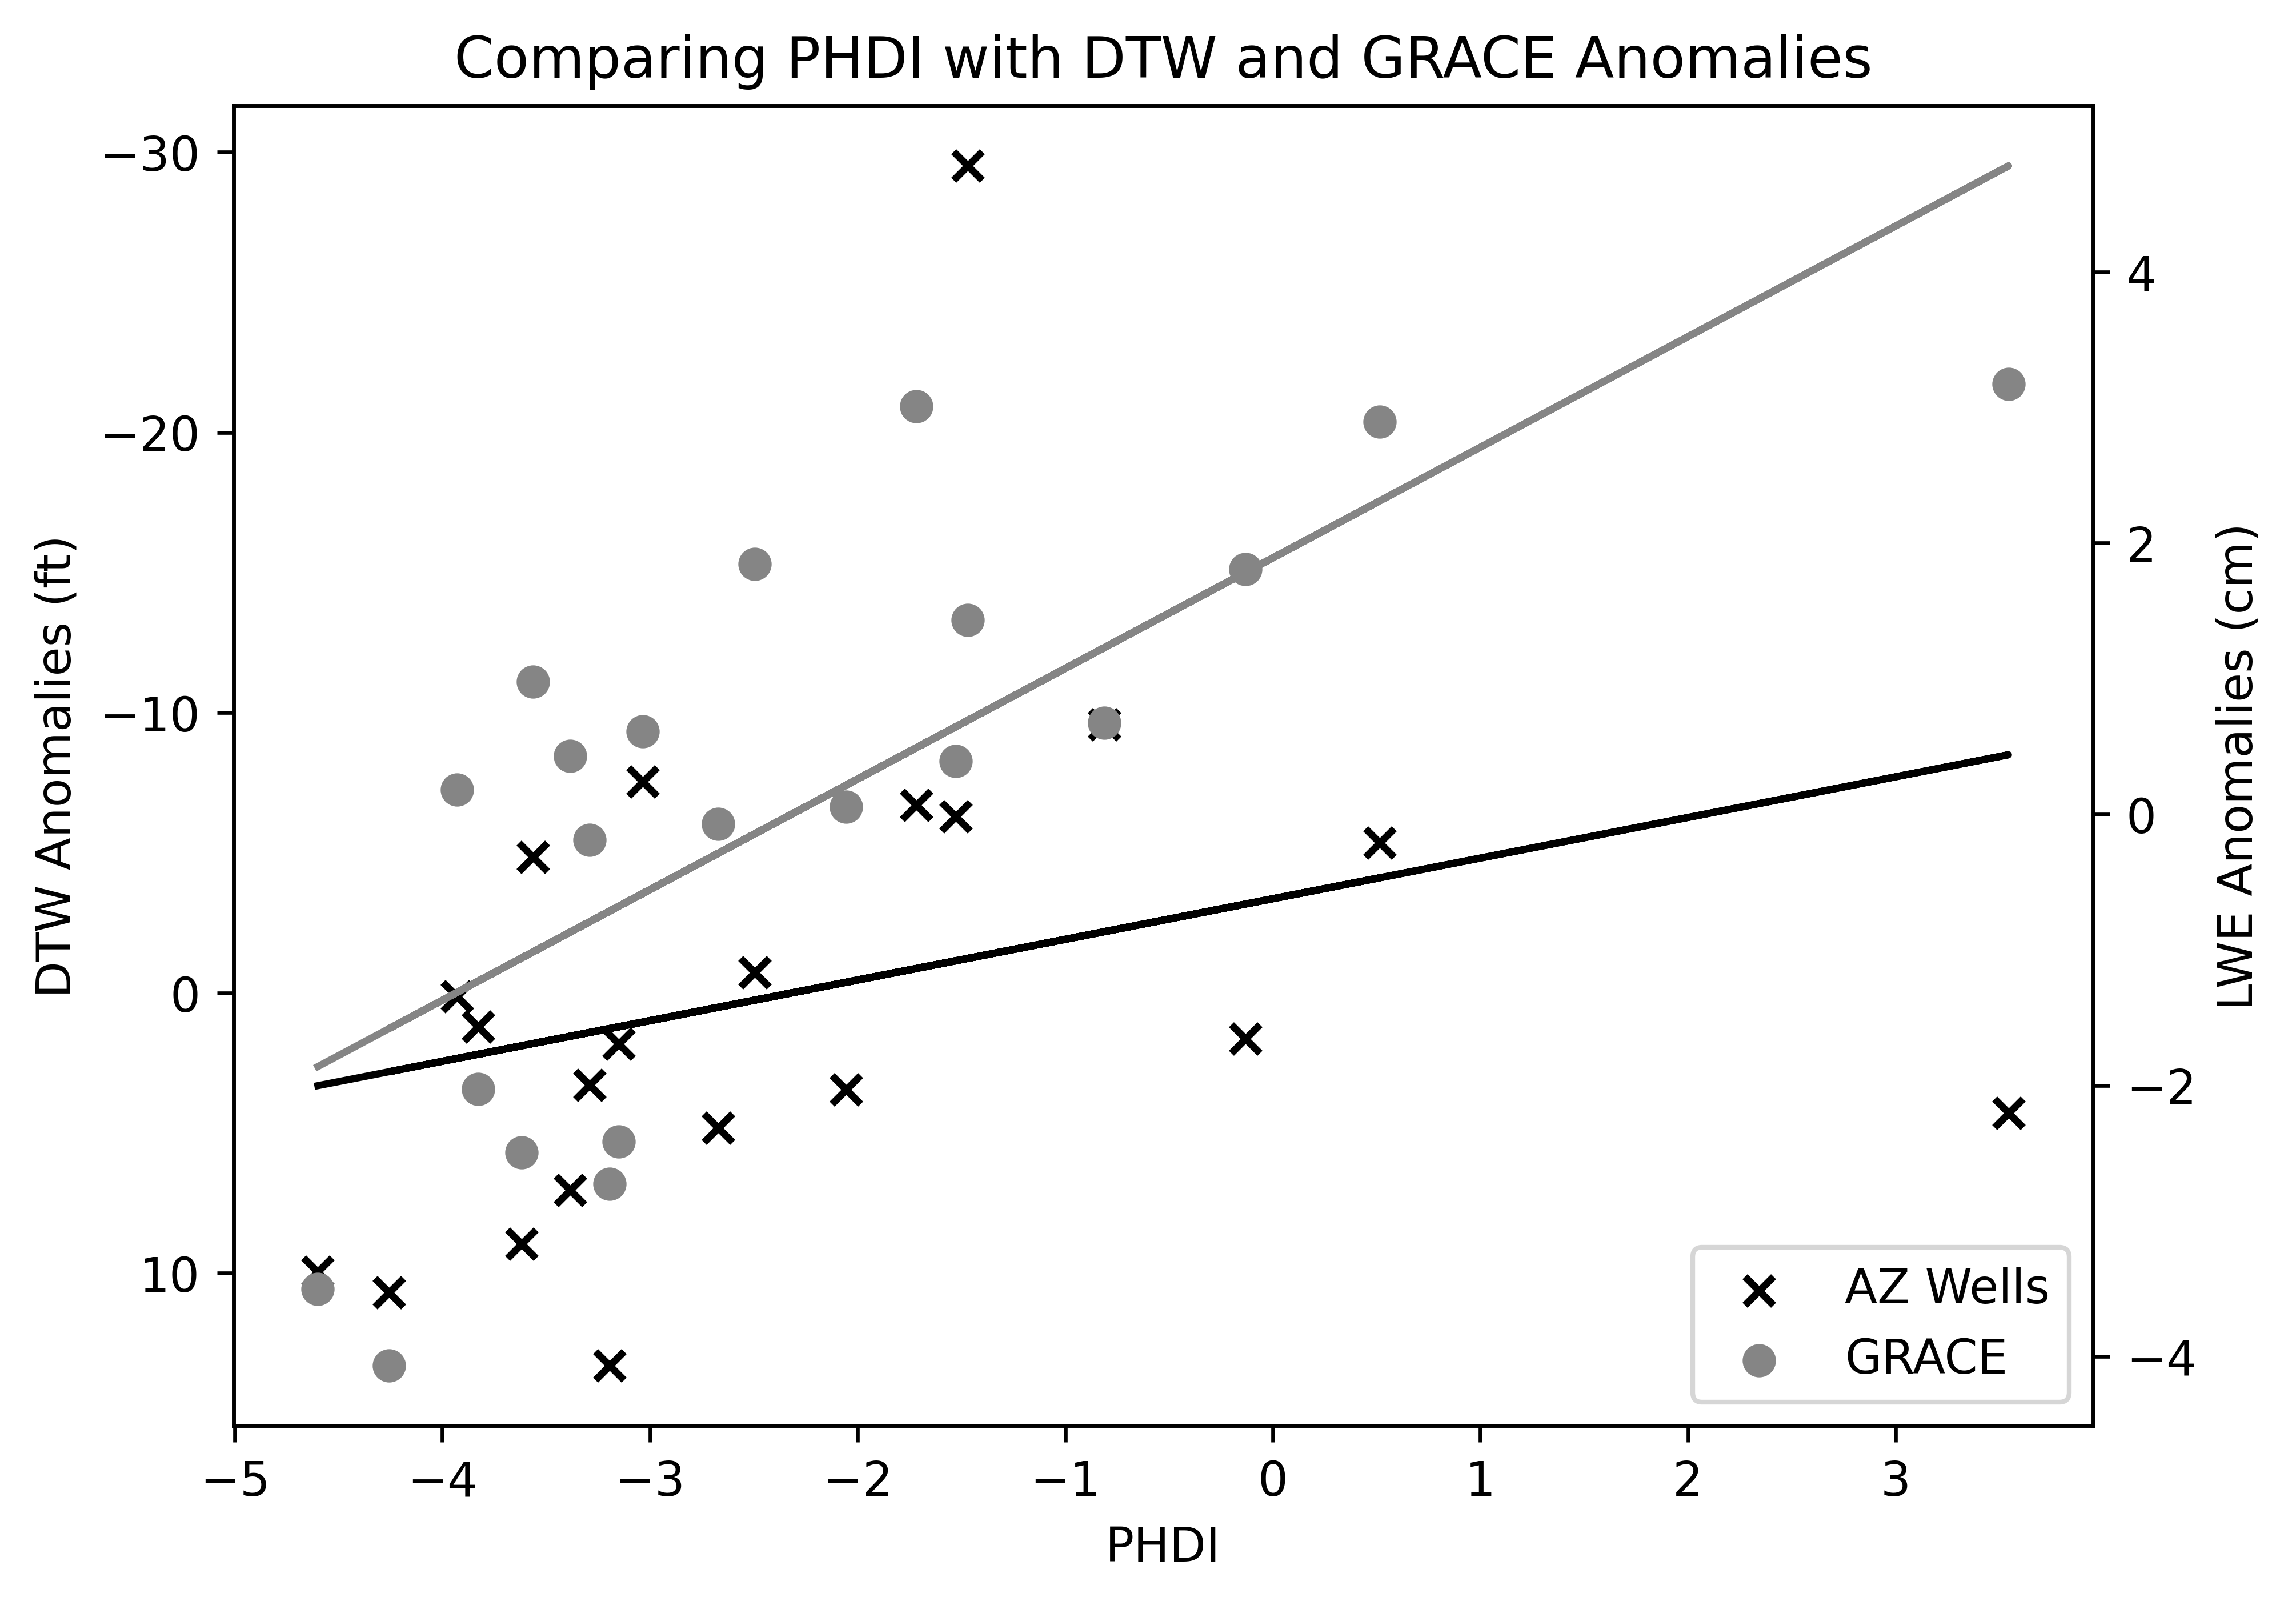

Results for GRACE Anomaly Correlation (2002-2022):
Kendall Correlation coefficient
 0:
  tau = 0.59
  pval = 0.0001
Spearman Correlation coefficient
 0:
  rho = 0.762
  pval = 0.0001
Pearson Correlation coefficient
 0:
  rsq = 0.531
  pval = 0.0002
Results for ADWR Well Anomalies (2002-2022):
Kendall Correlation coefficient
 0:
  tau = -0.352
  pval = 0.0262
Spearman Correlation coefficient
 0:
  rho = -0.505
  pval = 0.0195
Pearson Correlation coefficient
 0:
  rsq = 0.087
  pval = 0.1937



In [19]:
ds = lwe_anomalys_grace
ds2 = dtw_anomalys_AZwells
drought = drought_indices_wells

indice = 'PHDI'
# If running a shifted correlation analysis,
#    change this to however many # years; 0 is no lag
lag = 0

betterlabels = 'GRACE' 
betterlabels2 = 'AZ Wells' 

test_name = "GRACE Anomaly Correlation ("+str(minyear_grace)+"-"+str(maxyear)+")"
test_name2 = "ADWR Well Anomalies ("+str(minyear_wells)+"-"+str(maxyear)+")"

result = cf.correlation_test_2y(ds,ds2,drought,indice,lag
                                ,test_name,test_name2
                                ,betterlabels,betterlabels2
                                ,grace_color,az_wells_color)
print(result)

Results for ADWR Well Anomalies (2002-2022):
Kendall Correlation coefficient
 0:
  tau = -0.352
  pval = 0.0262
Spearman Correlation coefficient
 0:
  rho = -0.505
  pval = 0.0195
Pearson Correlation coefficient
 0:
  rsq = 0.087
  pval = 0.1937



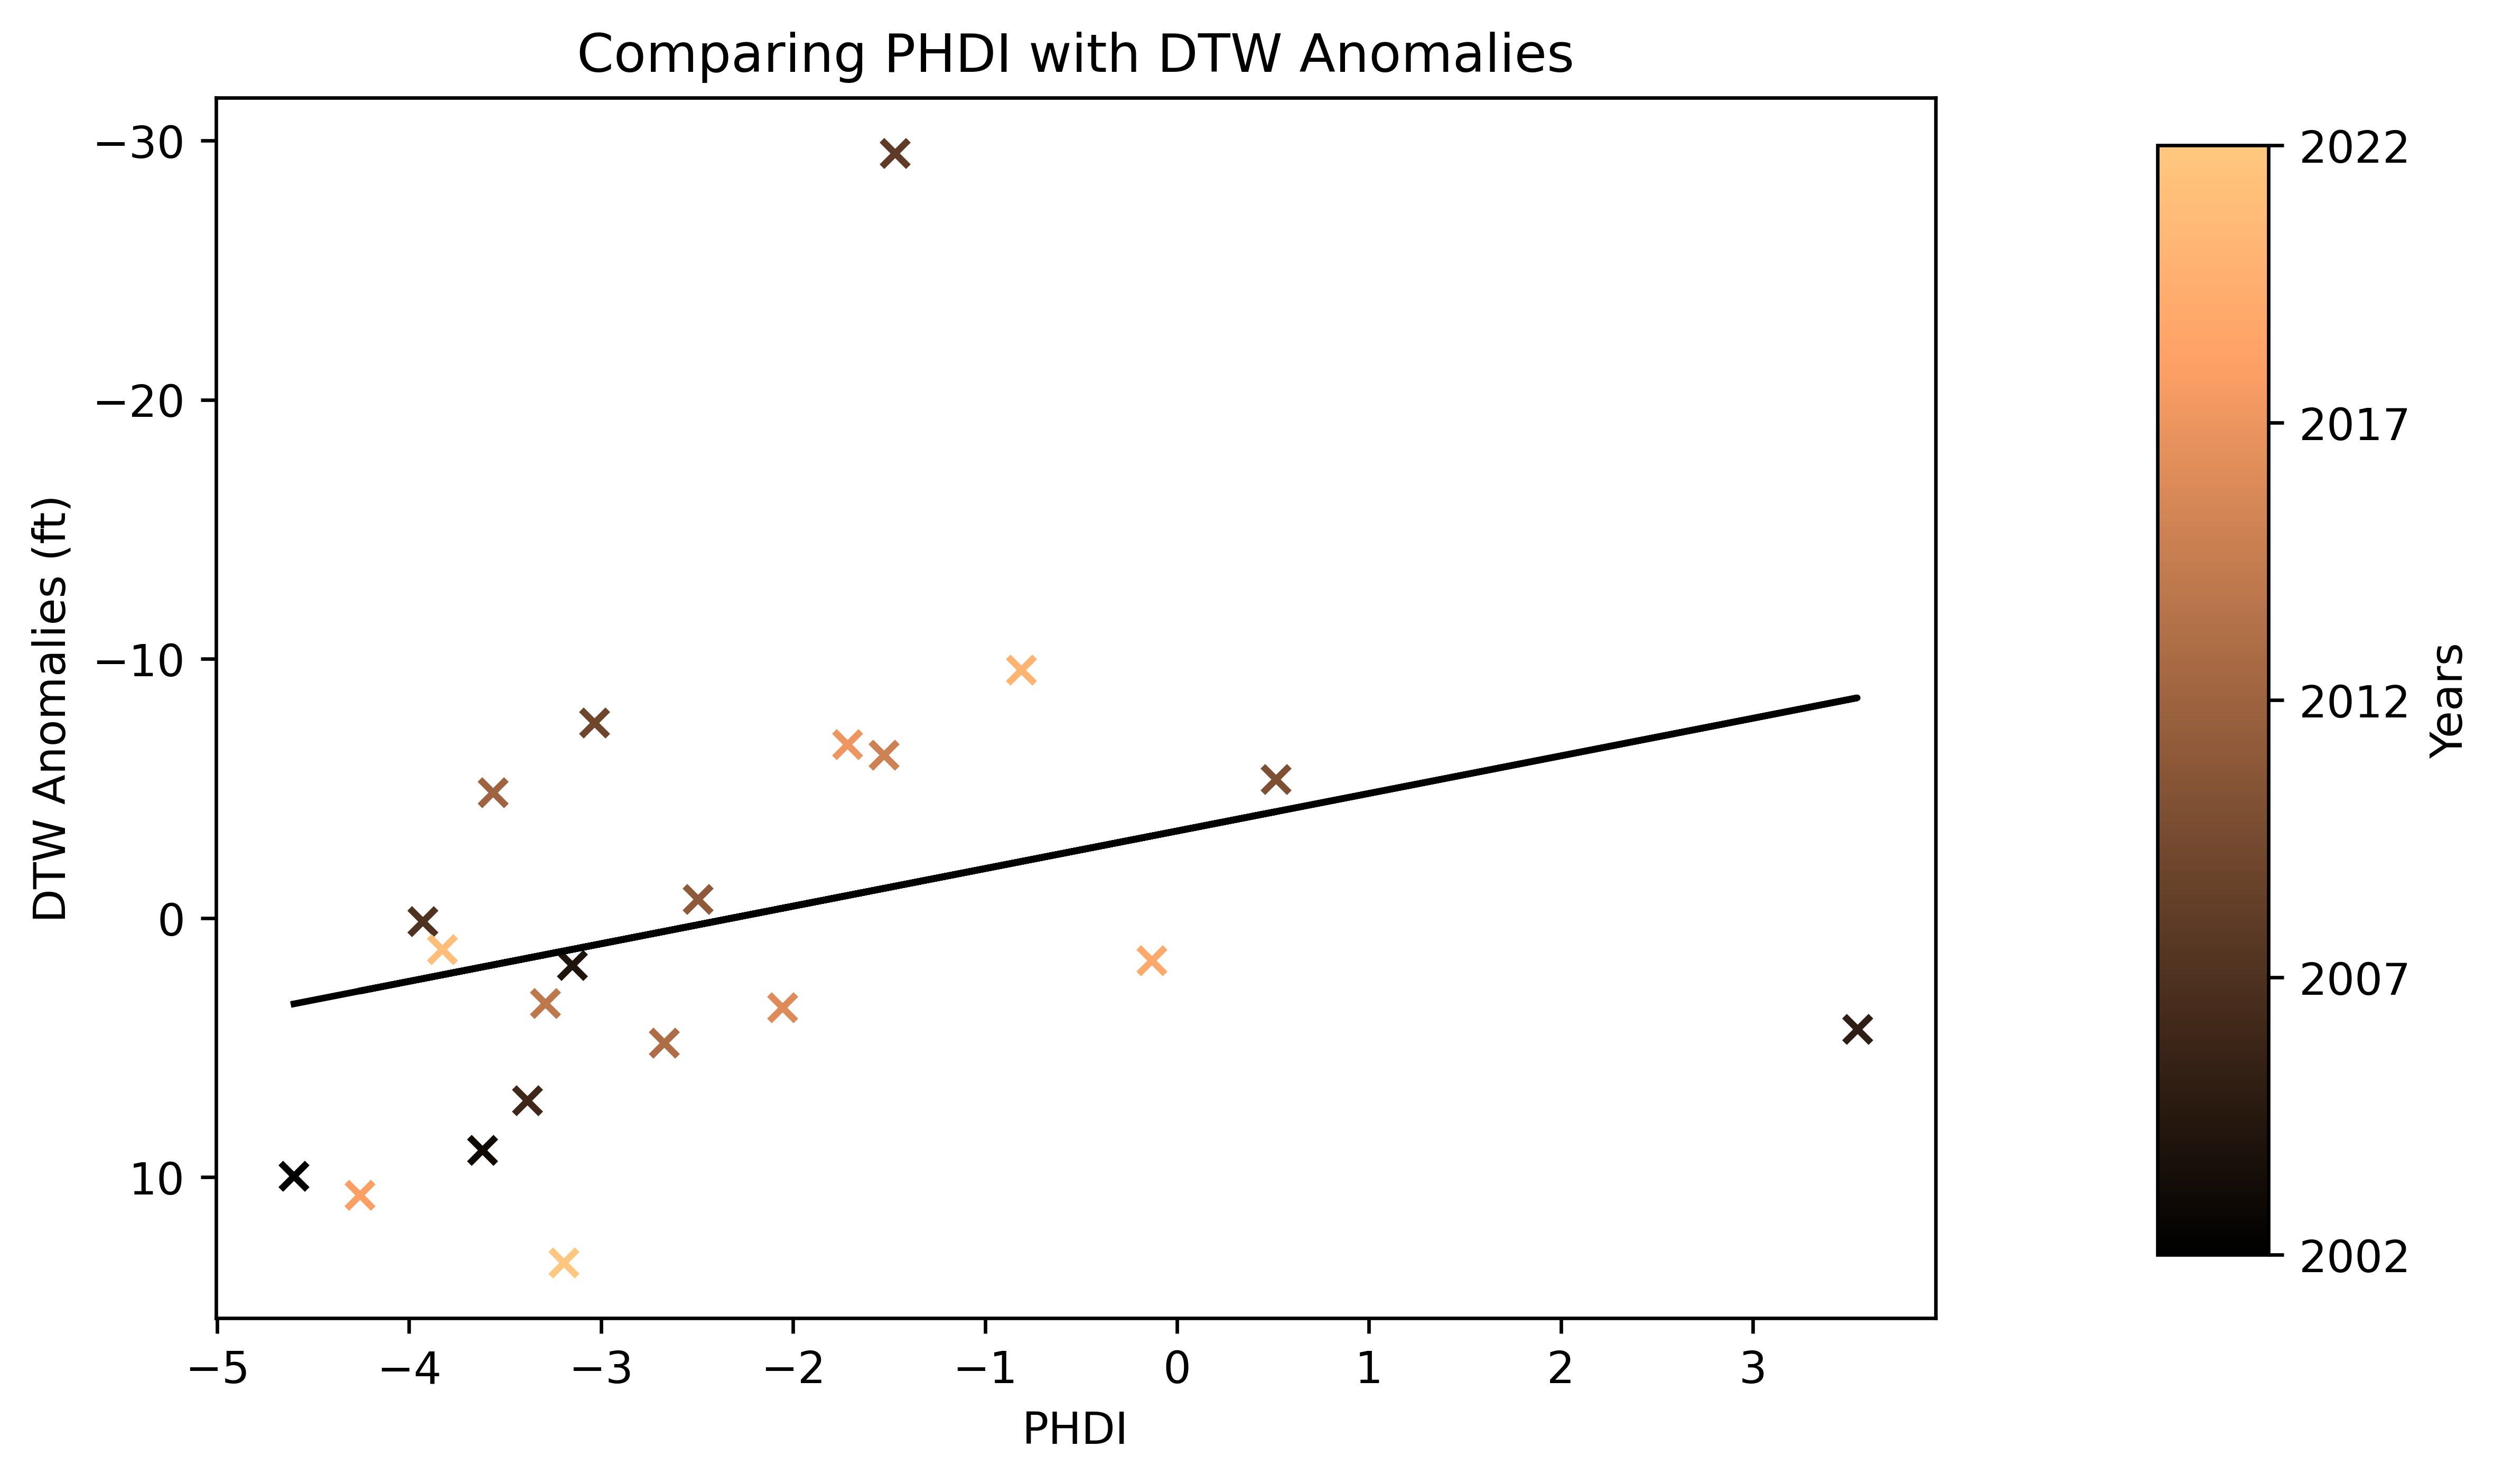

In [341]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as mcolors

indice = 'PHDI'
# Scatterplot of correlation values
ds = lwe_anomalys_grace
ds2 = dtw_anomalys_AZwells
ds2.columns = ds.columns

# # Define a threshold for extreme values
threshold = -20  # Example threshold value, adjust as needed

# # Replace extreme values with NaN
# ds2 = ds2.applymap(lambda x: np.nan if x < threshold else x)

test_name = "ADWR Well Anomalies ("+str(minyear_wells)+"-"+str(maxyear)+")"
drought = drought_indices_wells
lag = 0
result = cf.correlation_test(ds2, drought, indice, lag,test_name)
print(result)

# Ensure index names are consistent
ds.index.name = 'years'
ds2.index.name = 'years'
ds.index = ds.index.astype(int)
ds2.index = ds2.index.astype(int)

# Generate a color map based on the years
years = ds.index.union(ds2.index)
norm = mcolors.Normalize(vmin=years.min(), vmax=years.max())
colors = cm.copper(np.linspace(0, 1, len(years)))
color_map = {year: color for year, color in zip(years, colors)}

name = 'Comparing ' + indice + ' with DTW Anomalies'
columns = ds.columns
column_list = ds.columns.tolist()
columns2 = ds2.columns
column_list2 = ds2.columns.tolist()
betterlabels = ['GRACE']
betterlabels2 = ['AZ Wells']

fig, ax = plt.subplots(figsize=(7, 5))

x = drought_indices_grace[indice]
x2 = drought_indices_wells[indice]

# AZ Wells
for i, j in zip(column_list2, betterlabels2):
    y2 = ds2[i]
    for year in ds2.index:
        ax.scatter(x2.loc[year], y2.loc[year], label=f"{j} {year}", color=color_map[year], marker='x'
                   ,alpha=1
                   )
    # z = np.polyfit(x2, y2, 1)
    # p = np.poly1d(z)
    # plt.plot(x2, p(x2), '-', color=az_wells_color, alpha=1)  # Changed to black for clarity
    # Drop NaN values before fitting
    valid_mask = ~y2.isna()
    valid_x2 = x2[valid_mask]
    valid_y2 = y2[valid_mask]

    if len(valid_x2) > 0 and len(valid_y2) > 0:  # Ensure there are enough points to fit
        z = np.polyfit(valid_x2, valid_y2, 1)
        p = np.poly1d(z)
        plt.plot(valid_x2, p(valid_x2), '-', color='black', alpha=1)  # Changed to black for clarity

# Create a secondary y-axis
# ax2 = ax.twinx()

# GRACE
# for i, j in zip(column_list, betterlabels):
#     y = ds[i]
#     for year in ds.index:
#         ax2.scatter(x.loc[year], y.loc[year], label=f"{j} {year}", color=color_map[year])
#     z = np.polyfit(x, y, 1)
#     p = np.poly1d(z)
#     plt.plot(x, p(x), '-', color=grace_color)  # Changed to black for clarity

# Reverse the order of the secondary y-axis
ax.set_ylim(ax.get_ylim()[::-1])

ax.set_xlabel(indice)
# ax2.set_ylabel('LWE Anomalies (cm)')
ax.set_ylabel('DTW Anomalies (ft)')
ax.set_title(name, loc='center')
fig.set_dpi(600)

# Adding a color bar to represent the years, positioned manually
sm = plt.cm.ScalarMappable(cmap=cm.copper, norm=norm)
sm.set_array([])  # Only needed for older versions of matplotlib

# Specify the position of the color bar using a rectangle (x, y, width, height)
cbar_position = [1.0, 0.15, 0.05, 0.7]  # Adjust these values as needed
cbar_ax = fig.add_axes(cbar_position)
cbar = plt.colorbar(sm, cax=cbar_ax, orientation='vertical')
cbar.set_label('Years')

# Set color bar ticks to show every 5 years
tick_locations = np.arange(years.min(), years.max() + 1, 5)
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_locations)

plt.show()

# plt.savefig(outputpath+name, bbox_inches='tight')


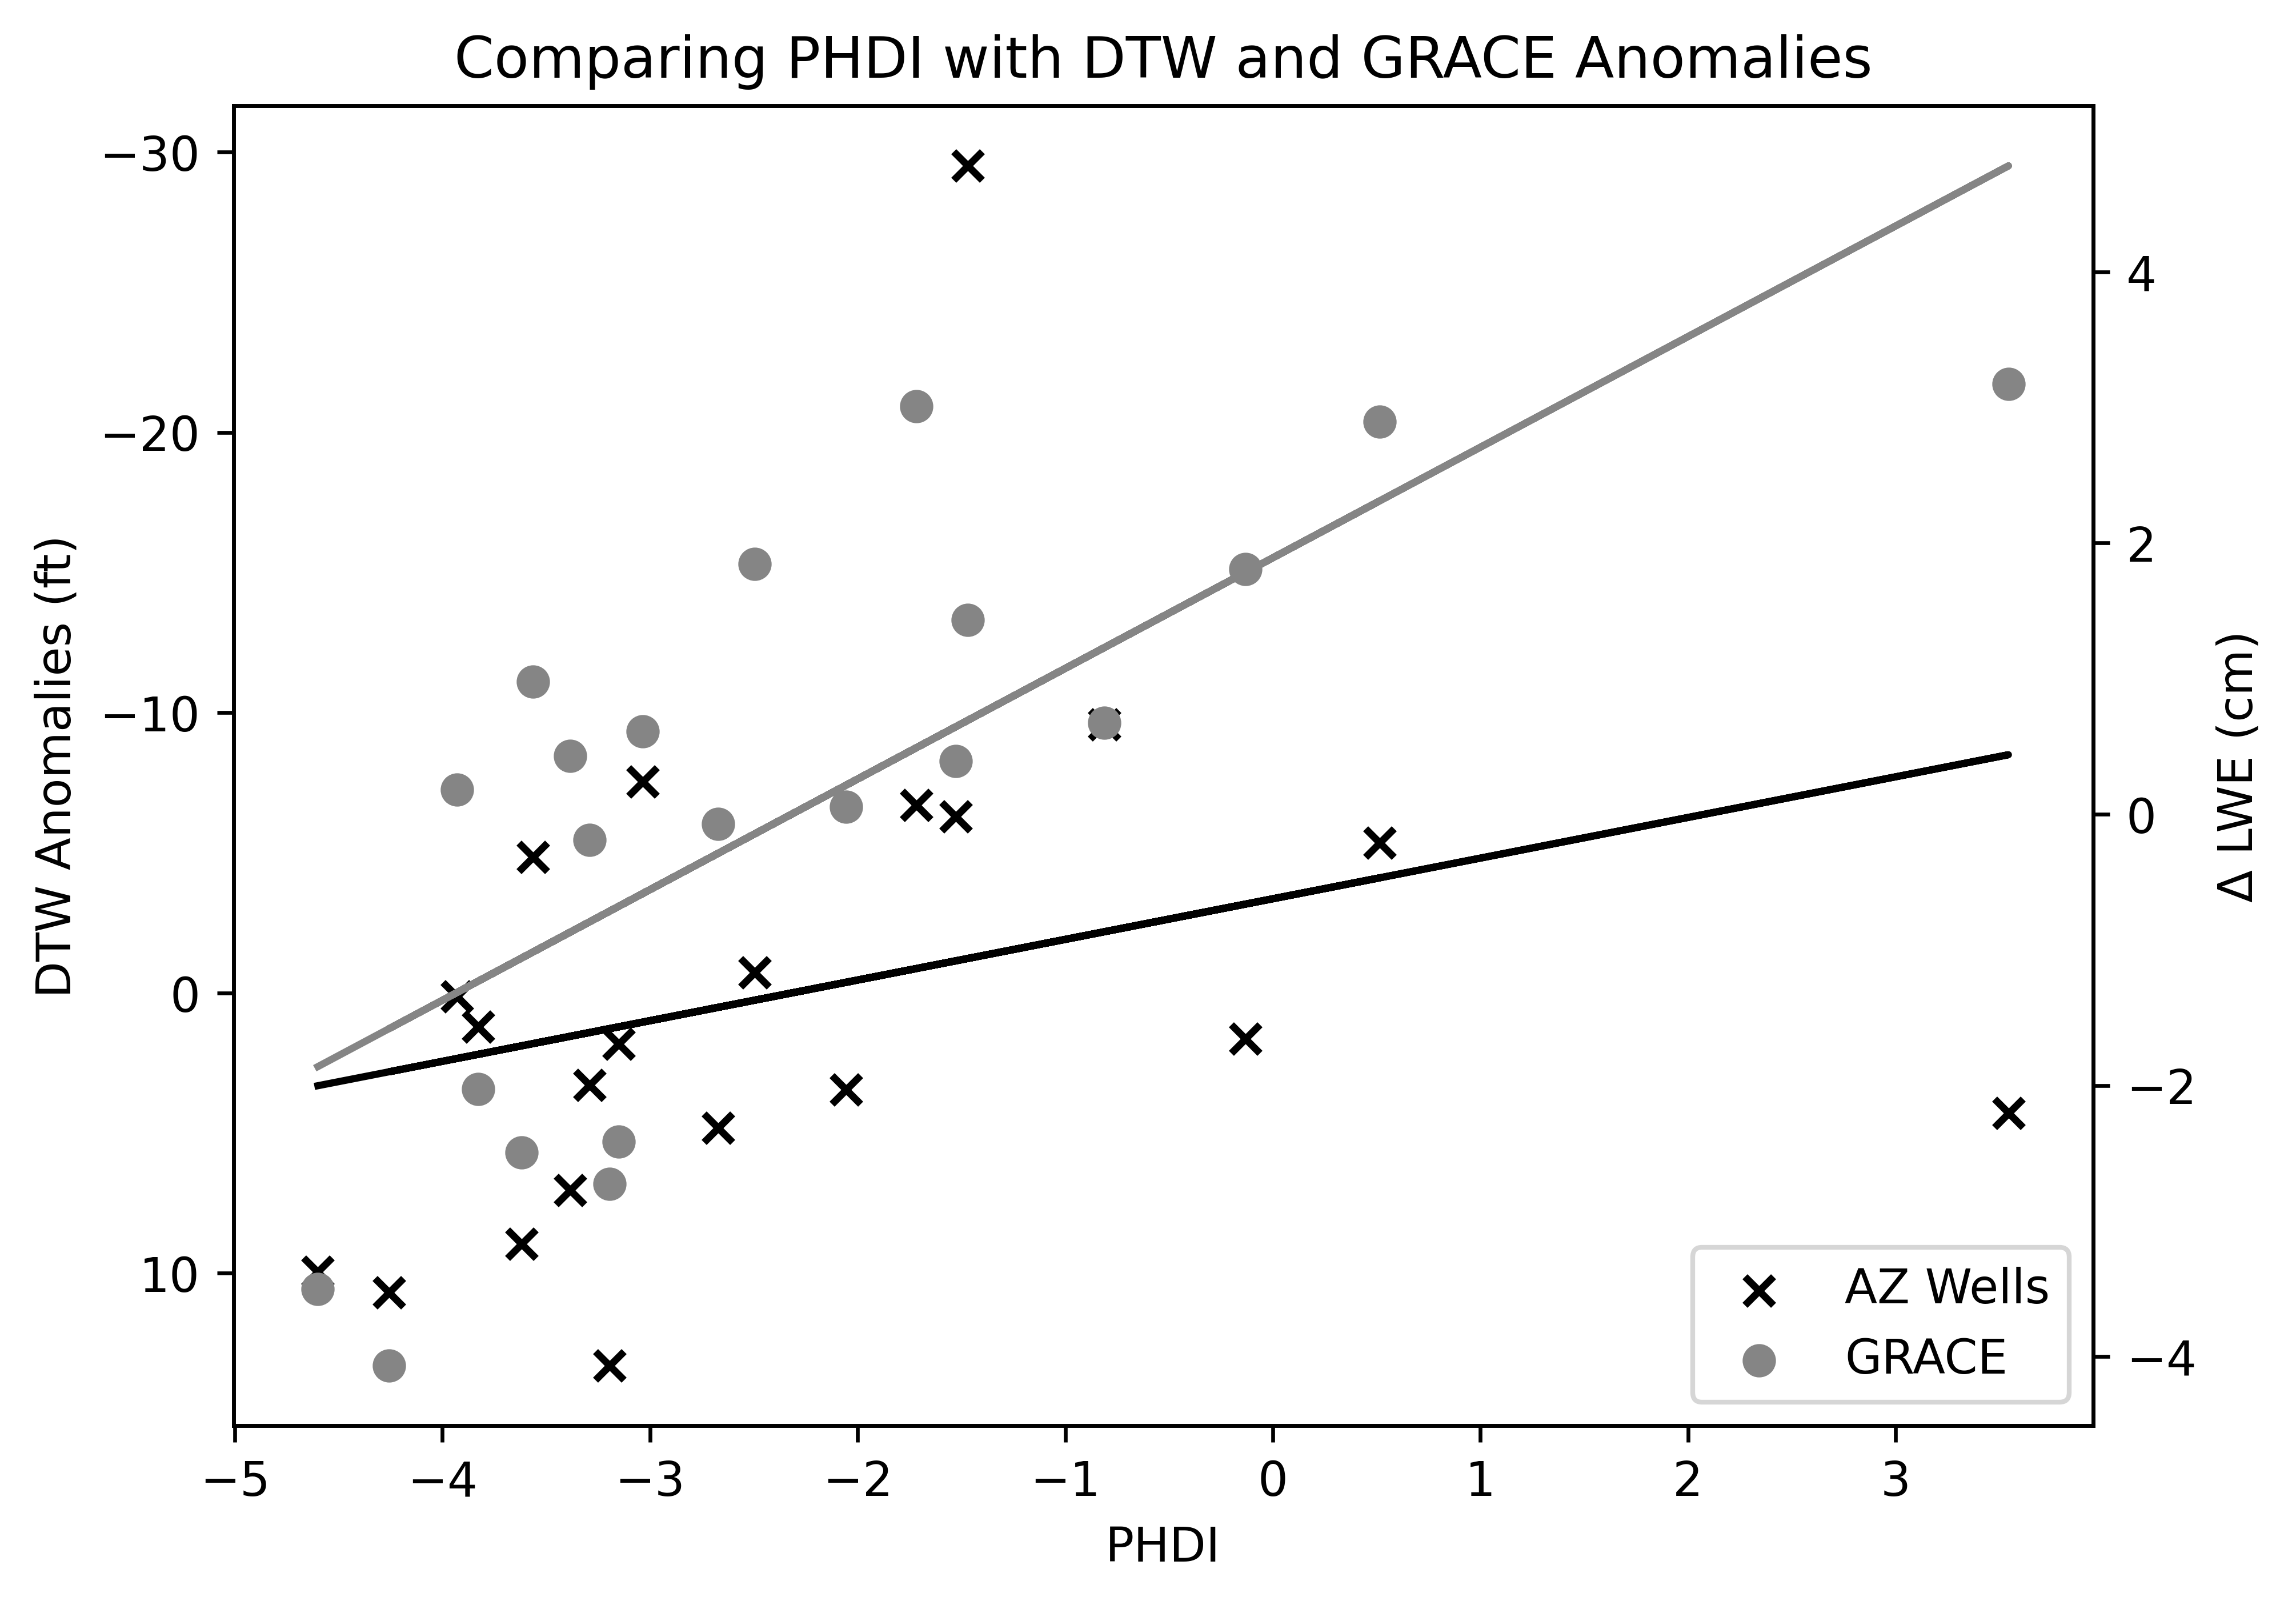

In [342]:
# Doing this for PHDI
indice = 'PHDI'
# Scatterplot of correlation values
ds = lwe_anomalys_grace
ds2 = dtw_anomalys_AZwells
ds2.columns = ds.columns

name = 'Comparing '+indice+' with DTW and GRACE Anomalies'
# del ds['Res']
columns = ds.columns
column_list = ds.columns.tolist()
columns2 = ds2.columns
column_list2 = ds2.columns.tolist()
betterlabels = ['GRACE'] 
betterlabels2 = ['AZ Wells'] 

fig, ax = plt.subplots(figsize=(7, 5))

x = drought_indices_grace[indice]
x2 = drought_indices_wells[indice]

# AZ Wells
for i, j in zip(column_list2, betterlabels2):
    y2 = ds2[i]
    ax.scatter(x2, y2, label=j, color=az_wells_color, marker='x')  # Using marker='x' for differentiation
    z = np.polyfit(x2, y2, 1)
    p = np.poly1d(z)
    ax.plot(x2, p(x2), '-', color=az_wells_color)  # Using '--' for differentiation

# Create a secondary y-axis
ax2 = ax.twinx()

# GRACE
for i, j in zip(column_list, betterlabels):
    y = ds[i]
    ax2.scatter(x, y, label=j, color=grace_color)
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x), '-', color=grace_color)

# Reverse the order of the secondary y-axis
# ax.set_ylim(250,150)
# ax2.set_ylim(-15,5)
ax.set_ylim(ax.get_ylim()[::-1])

ax.set_xlabel(indice)
ax2.set_ylabel(u'Δ LWE (cm)')
ax.set_ylabel('DTW Anomalies (ft)')  # Set label for the secondary axis
ax.set_title(name, loc='center')
fig.set_dpi(600)

# Combine legends for both axes
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='lower right')

plt.show()

# plt.savefig(outputpath+name, bbox_inches='tight') 

Creating a timeseries plot of anomalies

Text(2000.5, 29, 'Dry')

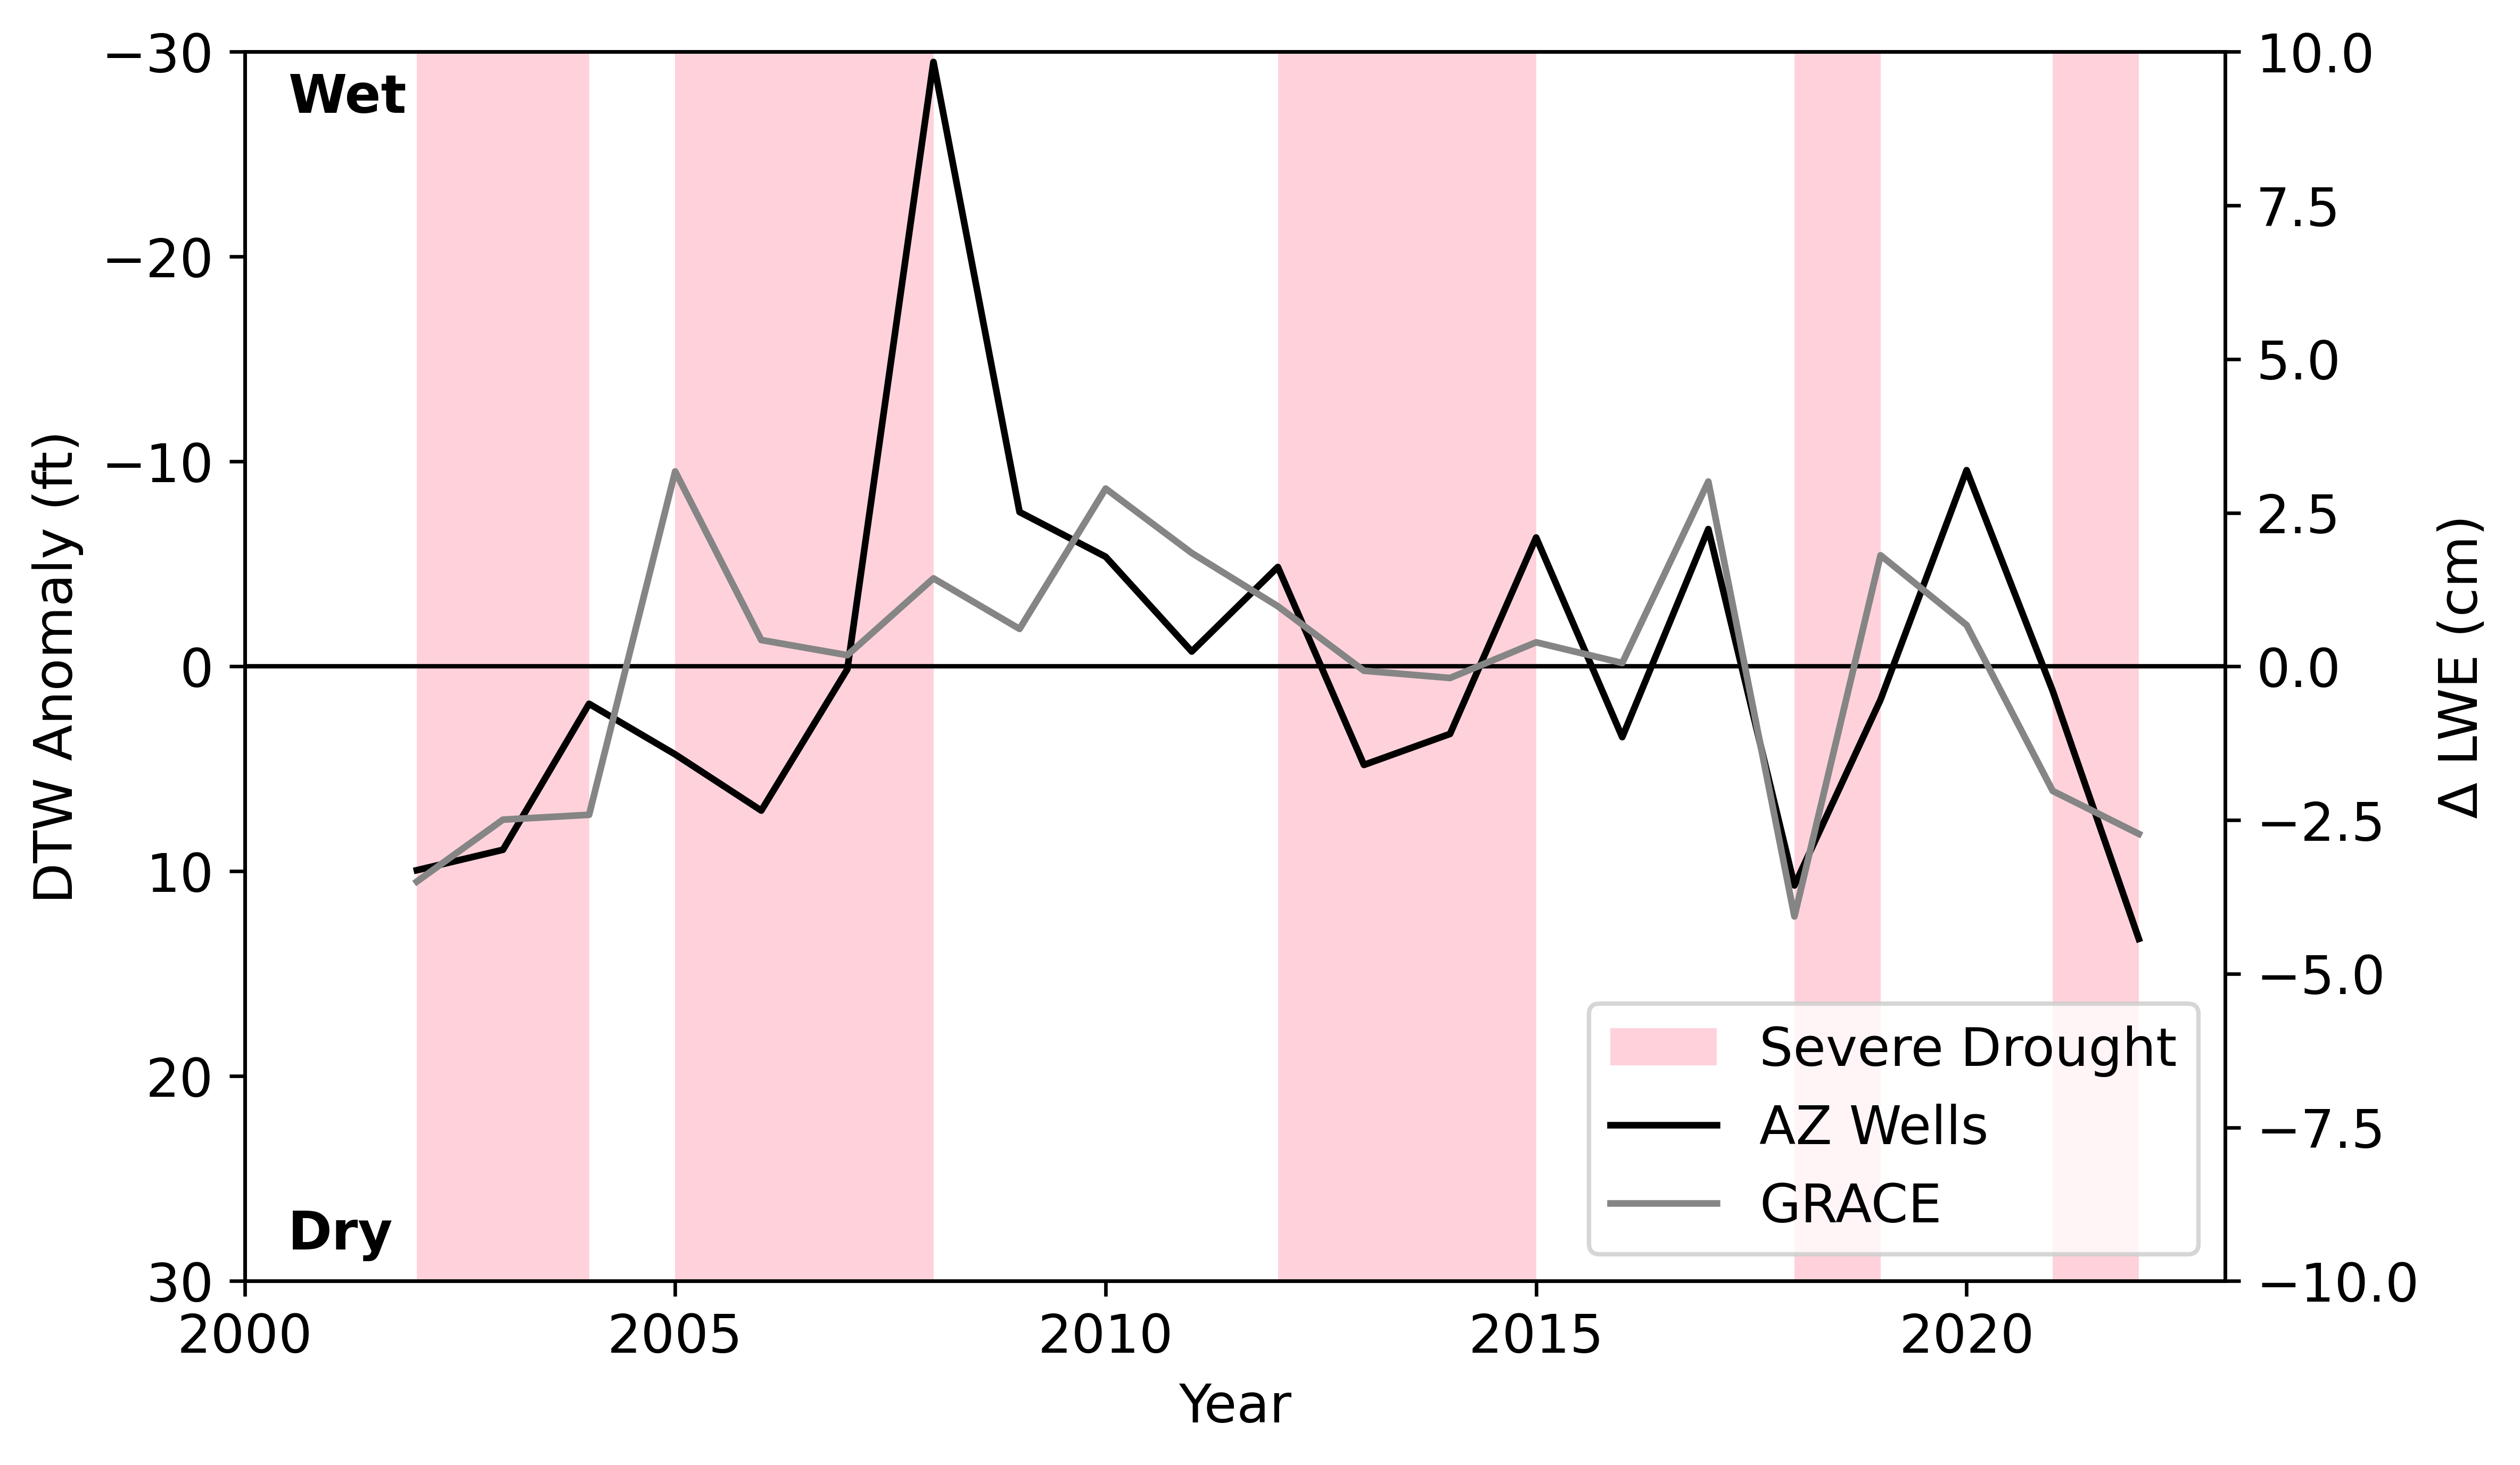

In [344]:
# For both GRACE and AZ Wells
ds = lwe_anomalys_grace
ds2 = dtw_anomalys_AZwells

min_yr = 2000
mx_yr = 2023

fig, ax = plt.subplots(1, 1, figsize = (8,5))

fsize = 12
well_ylimit = 30 #ft
grace_ylimit = 10 #cm

# Severe Drought Shading
a = 1988
b = 1990
c = 1995
d = 1996
e = 2021
f = 2022
g = 2002
h = 2004
i = 2005
j = 2008
k = 2012
l = 2015
m = 2018
n = 2019
plt.axvspan(a, b, color=drought_color, alpha=0.5, lw=0, label="Severe Drought")
plt.axvspan(c, d, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(e, f, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(g, h, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(i, j, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(k, l, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(m, n, color=drought_color, alpha=0.5, lw=0)

plt.axhspan(0,0,color='black',lw=1)

# ax.legend(loc='upper right')

# Plotting AZ on a secondary axis
ax.plot(ds2['0'], 
         label='AZ Wells', 
         color='black',zorder=1)
ax.set_ylim([well_ylimit, -well_ylimit])

# Plotting GRACE
ax2 = ax.twinx()
ax2.plot(ds['0'], 
        label='GRACE', 
        color=grace_color) 
ax2.set_ylim(-grace_ylimit,grace_ylimit)

# Adjust the x-axis and other labels
ax.set_xlim(min_yr,mx_yr)
ax.set_xlabel('Year', fontsize=fsize)
ax.tick_params(axis='x', labelsize=fsize)
ax.tick_params(axis='y', labelsize=fsize)
ax2.set_ylabel(u'Δ LWE (cm)',fontsize=fsize)
ax2.tick_params(axis='y', labelsize=fsize)
# ax.minorticks_on()
fig.set_dpi(600.0)

# ax2.set_ylim(ax2.get_ylim()[::-1])

ax.set_ylabel('DTW Anomaly (ft)',fontsize=fsize)
# ax2.legend(loc='lower right')
# ax.set_title('a)',loc='left',pad=15)

# Combine legends for both axes
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='lower right', fontsize=fsize)

# Adding text inside the plot
ax.text(min_yr+0.5, 1-well_ylimit, 'Wet', fontsize=fsize, fontweight='bold', ha='left', va='top')
ax.text(min_yr+0.5, well_ylimit-1, 'Dry', fontsize=fsize, fontweight='bold', ha='left', va='bottom')

# plt.savefig(figurepath+'Timeseries of DTW AZ Specific Anomalies', bbox_inches = 'tight')

Max/Min the Anomalies by Drought Period

In [345]:
# %% Average Anomaly for drought periods
ds = lwe_anomalys_grace.copy()
columns = ds.columns
column_list = ds.columns.tolist()

ds['Status'] = 'Normal-Wet'
# wlanalysis_period

for x,y in DROUGHT_YEARS.items():
        ds.loc[y, 'Status'] = 'Drought '+str(x)


lwe_drawdown_grace = ds.groupby(['Status']).min()
lwe_drawdown_grace
# ds

,0
Status,
Drought 3,-3.500186
Drought 4,0.183260
Drought 5,-0.187810
Drought 6,-4.067748
Drought 7,-2.025877
Normal-Wet,-2.724590


In [346]:
# %% Average Anomaly for drought periods
ds = dtw_anomalys_AZwells.copy()
columns = ds.columns
column_list = ds.columns.tolist()

ds['Status'] = 'Normal-Wet'
# wlanalysis_period

for x,y in DROUGHT_YEARS.items():
        ds.loc[y, 'Status'] = 'Drought '+str(x)


dtw_drawdown_wells = ds.groupby(['Status']).max()
dtw_drawdown_wells
# ds

,0
Status,
Drought 3,9.946906
Drought 4,7.034963
Drought 5,4.807107
Drought 6,10.690943
Drought 7,1.197330
Normal-Wet,13.298597


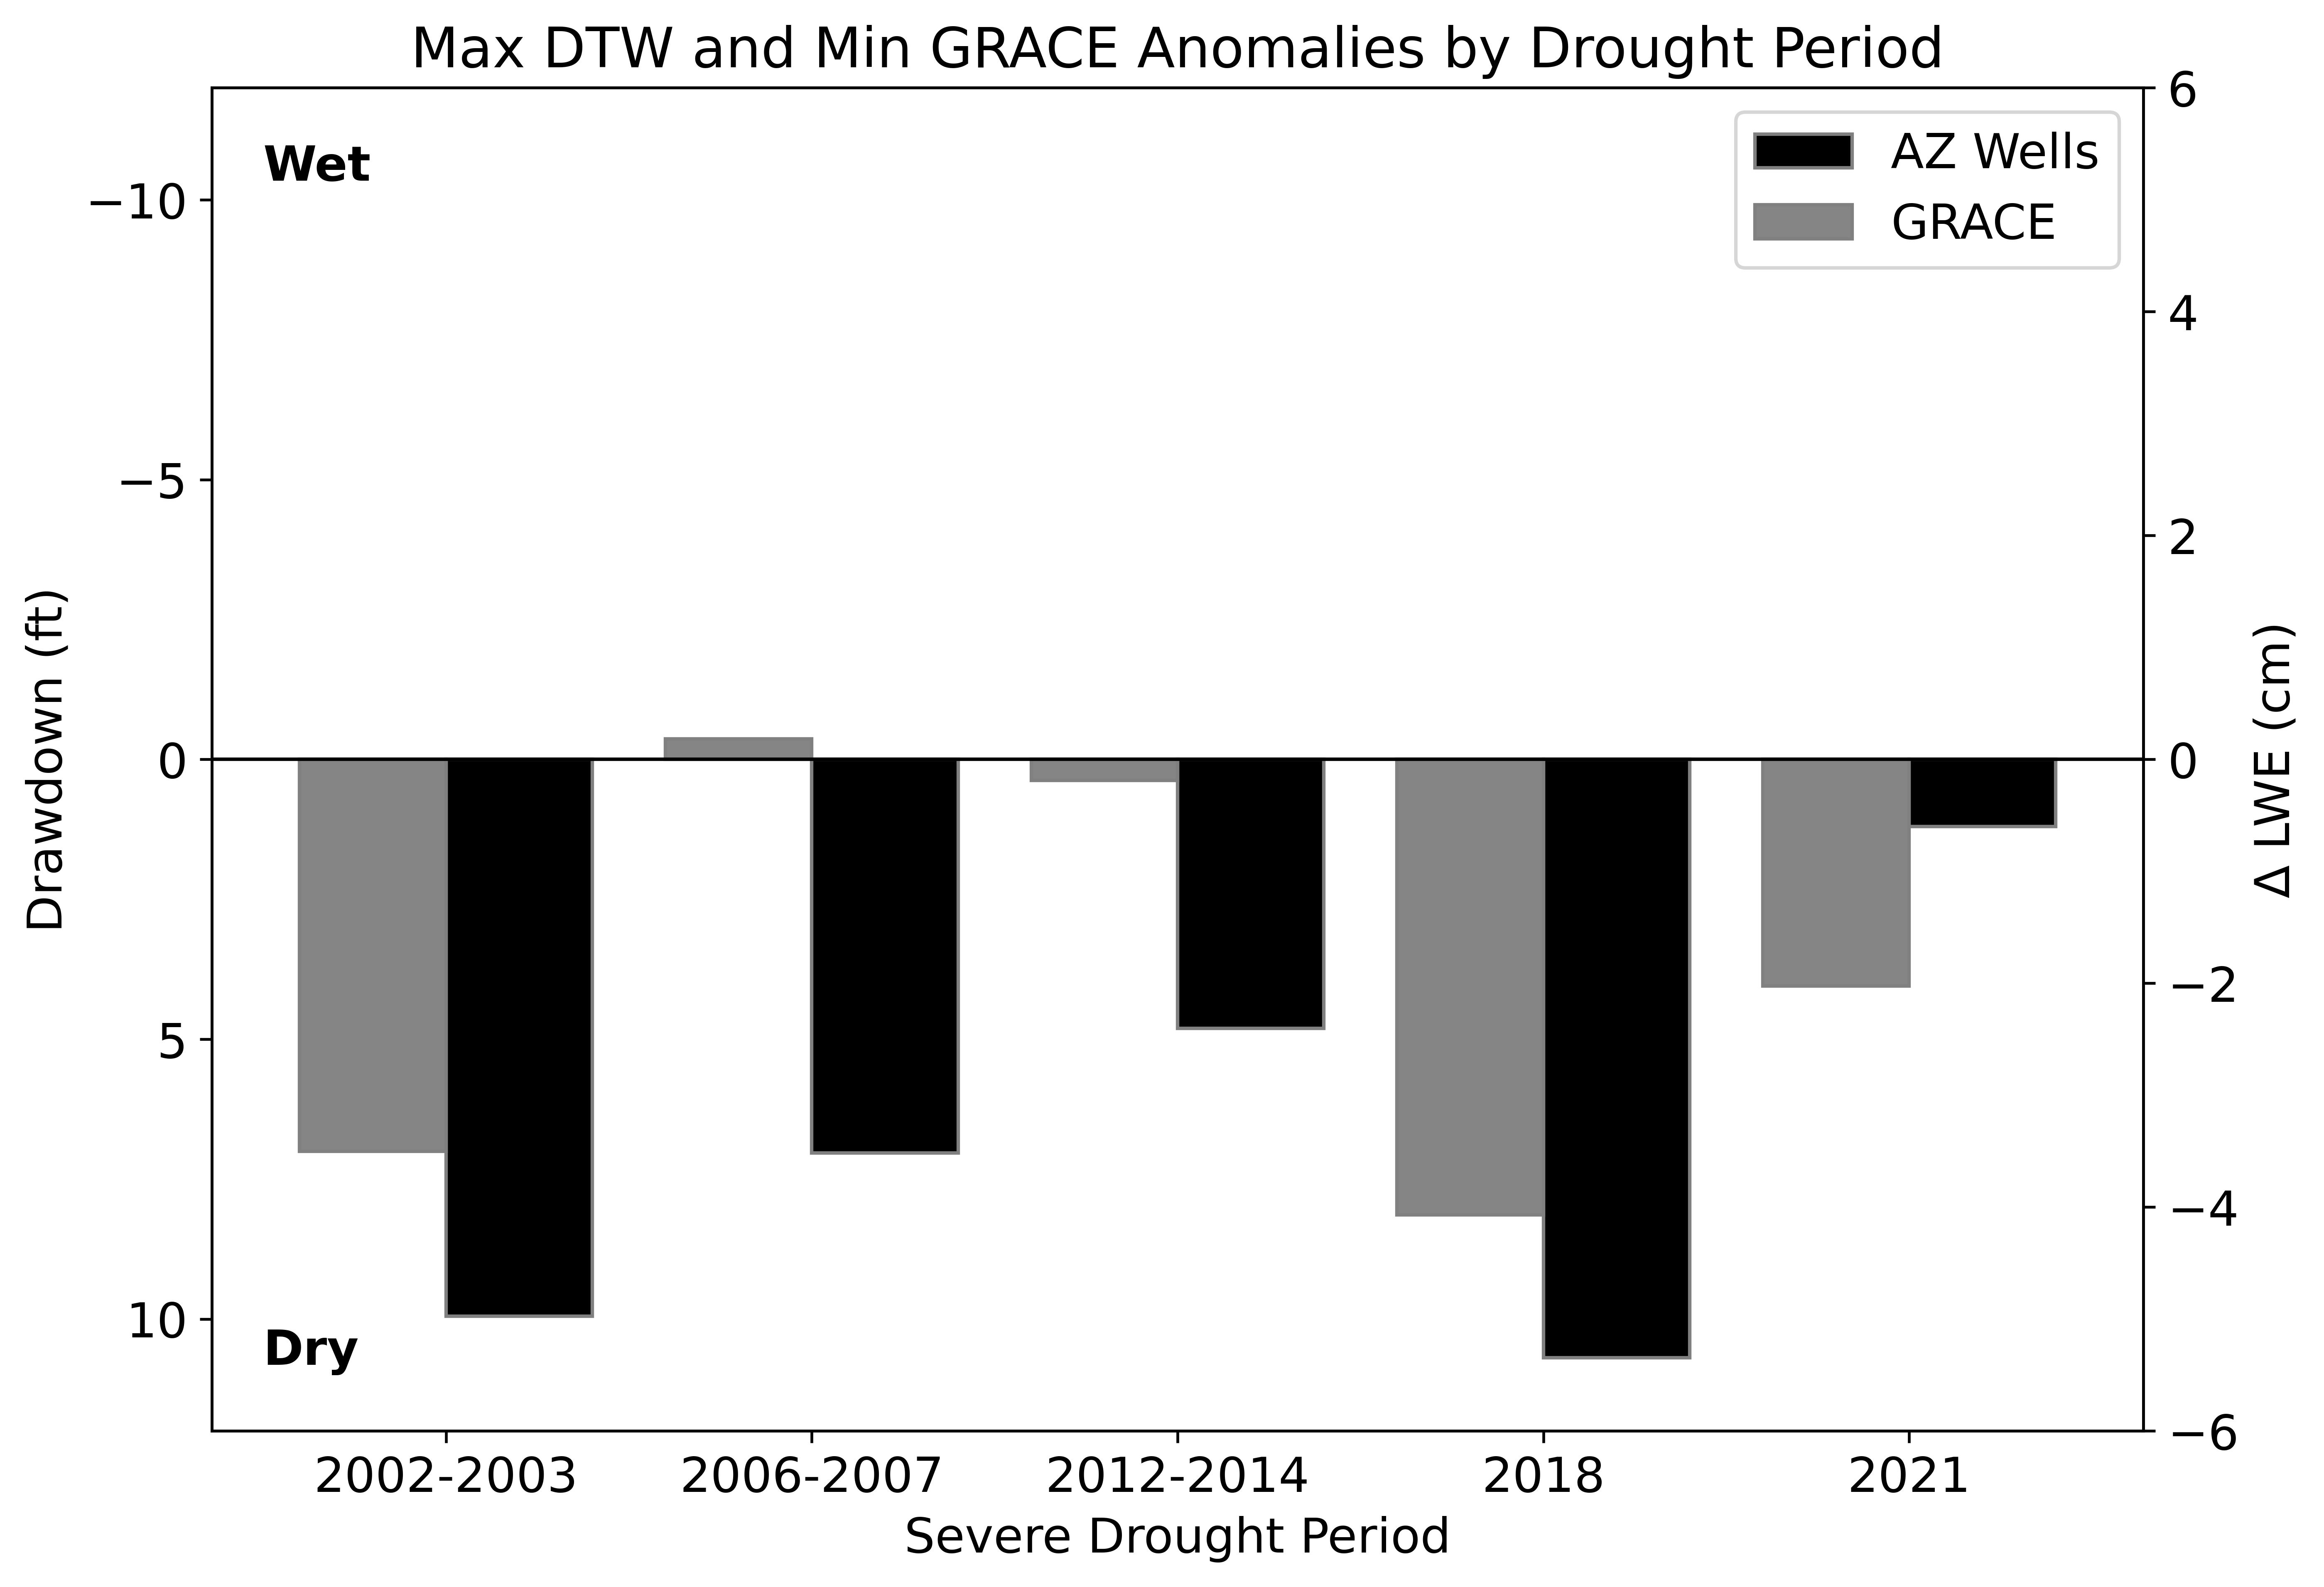

In [350]:
# Grouped Bar chart for drawdown (ft) / min GRACE anomaly
ds = lwe_drawdown_grace
ds2 = dtw_drawdown_wells
name = 'Max DTW and Min GRACE Anomalies by Drought Period'

group_colors = [grace_color, az_wells_color]  # Add another color for the second DataFrame

horlabel1 = u'Δ LWE (cm)'
horlabel2 = 'Drawdown (ft)'
fsize = 14
well_ylimit = 12
grace_ylimit = 6

yearlabels = [
    # "1989-1990",
    # '1996',
    '2002-2003',
    '2006-2007',
    '2012-2014',
    '2018',
    '2021',
    'Normal/Wet Years'
]

ds.index = yearlabels
ds = ds.transpose()
ds.index = betterlabels
del ds['Normal/Wet Years']
ds = ds.transpose()

ds2.index = yearlabels
ds2 = ds2.transpose()
ds2.index = betterlabels2
del ds2['Normal/Wet Years']
ds2 = ds2.transpose()

plt.rcParams["figure.dpi"] = 600
fig, ax1 = plt.subplots(figsize=(10, 7))

# Bar width
bar_width = 0.4

# Positions of the bars on the x-axis
r1 = np.arange(len(ds))
r2 = [x + bar_width for x in r1]

# Plotting the first DataFrame on the left y-axis
ax1.bar(r2, ds2.iloc[:, 0], color=group_colors[1], width=bar_width, edgecolor='grey', label=ds2.columns[0])
ax1.set_ylabel(horlabel2, fontsize=fsize)
ax1.set_ylim(well_ylimit,-well_ylimit)
ax1.tick_params(axis='y', labelsize=fsize)

# X-axis
ax1.set_xlabel('Severe Drought Period', fontsize=fsize)
ax1.set_xticks([r + bar_width / 2 for r in range(len(yearlabels))])
ax1.set_xticklabels(yearlabels, rotation=0, fontsize=fsize)

# Creating a twin Axes sharing the xaxis for the second DataFrame
ax2 = ax1.twinx()
ax2.bar(r1, ds.iloc[:, 0], color=group_colors[0], width=bar_width, edgecolor='grey', label=ds.columns[0])
ax2.set_ylabel(horlabel1, fontsize=fsize)
ax2.set_ylim(-grace_ylimit,grace_ylimit)
ax2.tick_params(axis='y', labelsize=fsize)

# Zero line
plt.axhspan(0,0,color='black',lw=1)

# Adding a legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right', fontsize=fsize)

# Adding text inside the plot
ax1.text(-0.3, 1-well_ylimit, 'Wet', fontsize=fsize, fontweight='bold', ha='left', va='top')
ax1.text(-0.3, well_ylimit-1, 'Dry', fontsize=fsize, fontweight='bold', ha='left', va='bottom')

# Setting the title
plt.title(name, fontsize=fsize + 2)

# Show the plot
plt.show()

# plt.savefig(figurepath + name + '_groupedchart', bbox_inches='tight')
